# Test

In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 60
EPOCHS = 600
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

## 1. Dataset

- The shape of the dataset is: (60, 32, 32, 3) => batch_size: 60, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (60, 18) => batch_size: 60, number of labels: 18


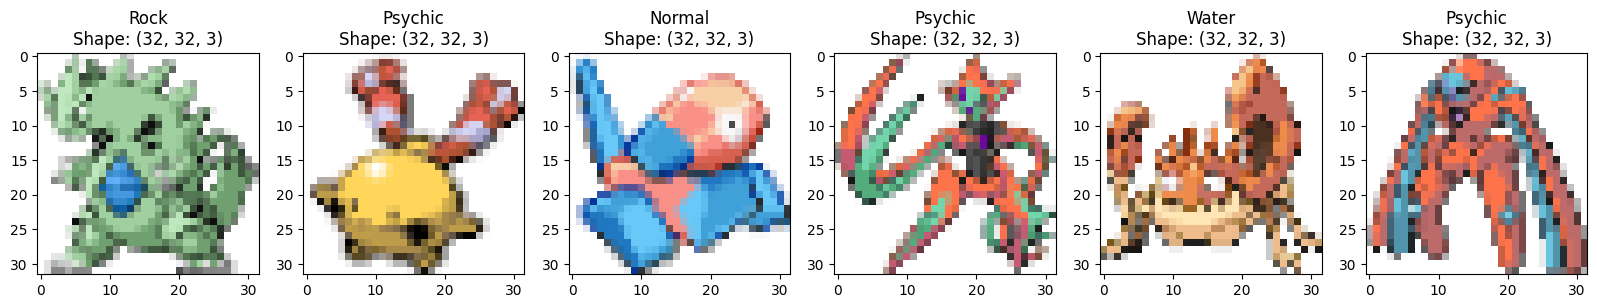

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

## 2. Model

In [8]:
# Create the model
# =====================================================================
u_net = build_unet(
    IMG_SIZE,
    NUM_CLASSES,
    initial_channels=64,
    channel_multiplier=[1, 2, 4, 8],
    has_attention=[False, False, True, True],
)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

In [9]:
u_net.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ y_input             │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      1,216 │ y_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64)        │        128 │ dense_42[0][0]    │
│ (GroupNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_input             │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_84       │ (None, 64)        │          0 │ group_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ t_input             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │      1,792 │ x_input[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      4,160 │ activation_84[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sinusoidal_time_em… │ (None, 128)       │          0 │ t_input[0][0]     │
│ (SinusoidalTimeEmb… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_82[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_86       │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 64)        │      8,256 │ sinusoidal_time_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_85       │ (None, 32, 32,    │          0 │ group_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_40          │ (None, 1, 1, 64)  │          0 │ activation_86[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_87       │ (None, 64)        │          0 │ dense_44[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_20         │ (None, 32, 32,    │          0 │ activation_85[0]… │
│ (Multiply)          │ 64)               │            │ reshape_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_41          │ (None, 1, 1, 64)  │          0 │ activation_87[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 32, 32,    │      1,792 │ x_input[0][0]   

 Total params: 30,892,035 (117.84 MB)

 Trainable params: 30,892,035 (117.84 MB)

 Non-trainable params: 0 (0.00 B)

### 2.1. Training

Epoch 1/600


I0000 00:00:1715665329.817043  165652 service.cc:145] XLA service 0x78b2f8004a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715665329.817064  165652 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715665330.678823  165652 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform


 1/68 ━━━━━━━━━━━━━━━━━━━━ 28:43 26s/step - loss: 1.9355

I0000 00:00:1715665344.792856  165652 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - loss: 0.6071
Epoch 2/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.2795
Epoch 3/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.2222
Epoch 4/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1750
Epoch 5/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1498
Epoch 6/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.1538
Epoch 7/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.1518
Epoch 8/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.1707
Epoch 9/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.1480
Epoch 10/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 0.2051
Epoch 11/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.1946
Epoch 12/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.1568
Epoch 13/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1324
Epoch 14/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1560
Epoch 15/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step -

Sampling sprite: 500it [00:44, 11.25it/s]                         


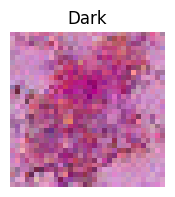

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 766ms/step - loss: 0.1087
Epoch 21/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.1546
Epoch 22/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1516
Epoch 23/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1418
Epoch 24/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1275
Epoch 25/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1716
Epoch 26/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1109
Epoch 27/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0950
Epoch 28/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1129
Epoch 29/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0737
Epoch 30/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1284
Epoch 31/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1480
Epoch 32/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1021
Epoch 33/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1437
Epoch 34/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss

Sampling sprite: 500it [00:45, 11.00it/s]                         


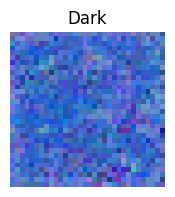

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 782ms/step - loss: 0.0809
Epoch 41/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.1216
Epoch 42/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1147
Epoch 43/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1176
Epoch 44/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1480
Epoch 45/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1076
Epoch 46/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1094
Epoch 47/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0898
Epoch 48/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1288
Epoch 49/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0844
Epoch 50/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1343
Epoch 51/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1020
Epoch 52/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1209
Epoch 53/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1474
Epoch 54/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss

Sampling sprite: 500it [00:43, 11.50it/s]                         


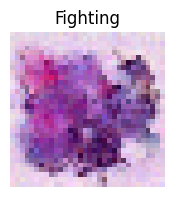

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 753ms/step - loss: 0.0994
Epoch 61/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1117
Epoch 62/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0983
Epoch 63/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1303
Epoch 64/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0883
Epoch 65/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1075
Epoch 66/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1258
Epoch 67/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1387
Epoch 68/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0649
Epoch 69/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0906
Epoch 70/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1158
Epoch 71/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1241
Epoch 72/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1311
Epoch 73/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1482
Epoch 74/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss

Sampling sprite: 500it [00:43, 11.63it/s]                         


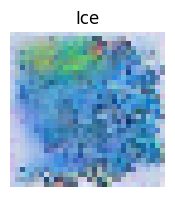

68/68 ━━━━━━━━━━━━━━━━━━━━ 50s 746ms/step - loss: 0.0981
Epoch 81/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1093
Epoch 82/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0873
Epoch 83/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0897
Epoch 84/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1161
Epoch 85/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0990
Epoch 86/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1177
Epoch 87/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1000
Epoch 88/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0995
Epoch 89/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0902
Epoch 90/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1072
Epoch 91/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1447
Epoch 92/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1106
Epoch 93/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1062
Epoch 94/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss

Sampling sprite: 500it [00:43, 11.60it/s]                         


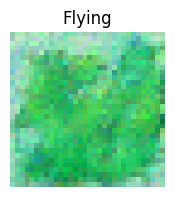

68/68 ━━━━━━━━━━━━━━━━━━━━ 50s 747ms/step - loss: 0.1052
Epoch 101/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1205
Epoch 102/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0975
Epoch 103/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1009
Epoch 104/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0948
Epoch 105/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0858
Epoch 106/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1212
Epoch 107/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0738
Epoch 108/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1300
Epoch 109/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0939
Epoch 110/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0928
Epoch 111/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1147
Epoch 112/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0791
Epoch 113/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0831
Epoch 114/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97

Sampling sprite: 500it [00:43, 11.42it/s]                         


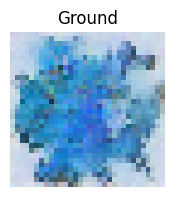

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 757ms/step - loss: 0.0820
Epoch 121/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0892
Epoch 122/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0907
Epoch 123/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1086
Epoch 124/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0776
Epoch 125/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1041
Epoch 126/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0813
Epoch 127/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0950
Epoch 128/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1113
Epoch 129/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0860
Epoch 130/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1008
Epoch 131/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0735
Epoch 132/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1194
Epoch 133/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1020
Epoch 134/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97

Sampling sprite: 500it [00:44, 11.34it/s]                         


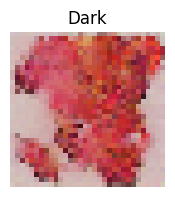

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 762ms/step - loss: 0.0904
Epoch 141/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1155
Epoch 142/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1027
Epoch 143/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0939
Epoch 144/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0889
Epoch 145/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0824
Epoch 146/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1100
Epoch 147/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1026
Epoch 148/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0931
Epoch 149/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1071
Epoch 150/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0910
Epoch 151/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1010
Epoch 152/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1011
Epoch 153/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1122
Epoch 154/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97

Sampling sprite: 500it [00:44, 11.14it/s]                         


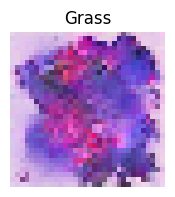

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 774ms/step - loss: 0.1005
Epoch 161/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1265
Epoch 162/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0991
Epoch 163/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1016
Epoch 164/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1036
Epoch 165/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0781
Epoch 166/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0709
Epoch 167/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0891
Epoch 168/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0997
Epoch 169/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1009
Epoch 170/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1240
Epoch 171/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0902
Epoch 172/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0838
Epoch 173/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0993
Epoch 174/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97

Sampling sprite: 500it [00:44, 11.17it/s]                         


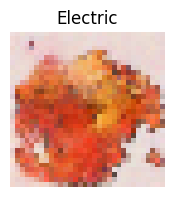

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 771ms/step - loss: 0.0985
Epoch 181/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0905
Epoch 182/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0763
Epoch 183/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0770
Epoch 184/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0903
Epoch 185/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1101
Epoch 186/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0699
Epoch 187/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0969
Epoch 188/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1109
Epoch 189/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0834
Epoch 190/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0996
Epoch 191/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0892
Epoch 192/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1034
Epoch 193/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0800
Epoch 194/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.08it/s]                         


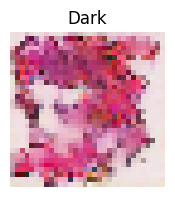

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 777ms/step - loss: 0.1089
Epoch 201/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0925
Epoch 202/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1056
Epoch 203/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1026
Epoch 204/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0865
Epoch 205/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1115
Epoch 206/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1080
Epoch 207/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0821
Epoch 208/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1282
Epoch 209/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1121
Epoch 210/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1228
Epoch 211/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0806
Epoch 212/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1217
Epoch 213/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 214/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.16it/s]                         


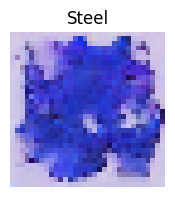

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 773ms/step - loss: 0.1006
Epoch 221/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0705
Epoch 222/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0814
Epoch 223/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0998
Epoch 224/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0951
Epoch 225/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0629
Epoch 226/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0739
Epoch 227/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0672
Epoch 228/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0760
Epoch 229/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0788
Epoch 230/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0783
Epoch 231/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0973
Epoch 232/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0653
Epoch 233/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0889
Epoch 234/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.28it/s]                         


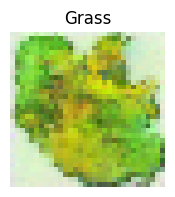

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 766ms/step - loss: 0.0846
Epoch 241/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0622
Epoch 242/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0864
Epoch 243/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0834
Epoch 244/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0891
Epoch 245/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0971
Epoch 246/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1035
Epoch 247/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0907
Epoch 248/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0839
Epoch 249/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0968
Epoch 250/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1080
Epoch 251/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1002
Epoch 252/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0933
Epoch 253/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0913
Epoch 254/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.34it/s]                         


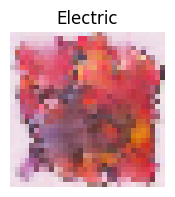

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 762ms/step - loss: 0.0783
Epoch 261/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1211
Epoch 262/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0853
Epoch 263/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0769
Epoch 264/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0822
Epoch 265/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0779
Epoch 266/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0844
Epoch 267/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0773
Epoch 268/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0835
Epoch 269/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0819
Epoch 270/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1020
Epoch 271/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 272/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0602
Epoch 273/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0794
Epoch 274/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.23it/s]                         


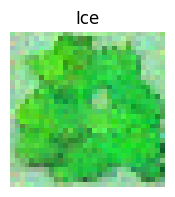

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 769ms/step - loss: 0.0908
Epoch 281/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0794
Epoch 282/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0906
Epoch 283/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0899
Epoch 284/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1015
Epoch 285/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1125
Epoch 286/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0825
Epoch 287/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0758
Epoch 288/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0932
Epoch 289/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0843
Epoch 290/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1008
Epoch 291/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0881
Epoch 292/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0700
Epoch 293/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0755
Epoch 294/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.05it/s]                         


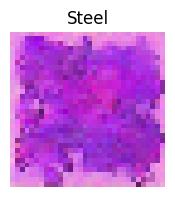

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 780ms/step - loss: 0.0901
Epoch 301/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0736
Epoch 302/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0976
Epoch 303/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0971
Epoch 304/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0862
Epoch 305/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0771
Epoch 306/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0778
Epoch 307/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0879
Epoch 308/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0842
Epoch 309/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0985
Epoch 310/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0931
Epoch 311/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0978
Epoch 312/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1102
Epoch 313/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1049
Epoch 314/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.91it/s]                         


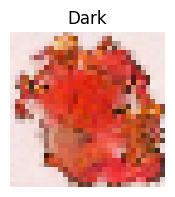

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - loss: 0.0829
Epoch 321/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0914
Epoch 322/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0854
Epoch 323/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0630
Epoch 324/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0822
Epoch 325/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0860
Epoch 326/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0766
Epoch 327/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0704
Epoch 328/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0610
Epoch 329/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0806
Epoch 330/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1045
Epoch 331/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0847
Epoch 332/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0724
Epoch 333/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0811
Epoch 334/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.05it/s]                         


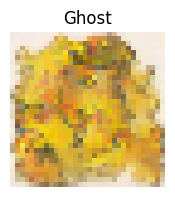

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 780ms/step - loss: 0.0924
Epoch 341/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0904
Epoch 342/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1035
Epoch 343/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1007
Epoch 344/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0949
Epoch 345/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0873
Epoch 346/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0870
Epoch 347/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0739
Epoch 348/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0986
Epoch 349/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0787
Epoch 350/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1189
Epoch 351/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1019
Epoch 352/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0935
Epoch 353/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0901
Epoch 354/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.24it/s]                         


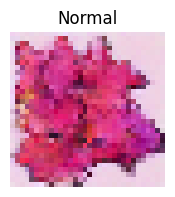

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 768ms/step - loss: 0.0847
Epoch 361/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0852
Epoch 362/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1089
Epoch 363/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1071
Epoch 364/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1084
Epoch 365/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0479
Epoch 366/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0813
Epoch 367/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0833
Epoch 368/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0721
Epoch 369/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0890
Epoch 370/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1005
Epoch 371/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1109
Epoch 372/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0975
Epoch 373/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0703
Epoch 374/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.10it/s]                         


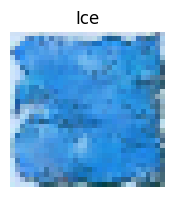

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 777ms/step - loss: 0.0896
Epoch 381/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1003
Epoch 382/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1063
Epoch 383/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1016
Epoch 384/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0946
Epoch 385/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0981
Epoch 386/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0784
Epoch 387/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1059
Epoch 388/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1045
Epoch 389/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1093
Epoch 390/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0825
Epoch 391/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0985
Epoch 392/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0968
Epoch 393/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0721
Epoch 394/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.96it/s]                         


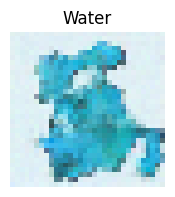

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 786ms/step - loss: 0.0813
Epoch 401/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0712
Epoch 402/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0977
Epoch 403/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0886
Epoch 404/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1009
Epoch 405/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0751
Epoch 406/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0975
Epoch 407/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0682
Epoch 408/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0729
Epoch 409/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0908
Epoch 410/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0643
Epoch 411/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0922
Epoch 412/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0618
Epoch 413/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0712
Epoch 414/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.00it/s]                         


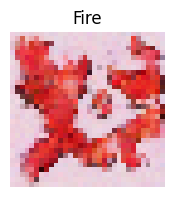

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 783ms/step - loss: 0.0651
Epoch 421/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0706
Epoch 422/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0911
Epoch 423/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0886
Epoch 424/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0647
Epoch 425/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0911
Epoch 426/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0875
Epoch 427/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0952
Epoch 428/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0722
Epoch 429/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0915
Epoch 430/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0901
Epoch 431/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0903
Epoch 432/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0913
Epoch 433/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1028
Epoch 434/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.87it/s]                         


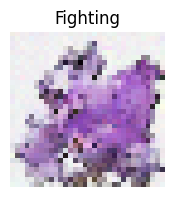

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0756
Epoch 441/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0833
Epoch 442/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0836
Epoch 443/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0820
Epoch 444/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0812
Epoch 445/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0775
Epoch 446/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1076
Epoch 447/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1175
Epoch 448/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 449/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1097
Epoch 450/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0957
Epoch 451/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0715
Epoch 452/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0973
Epoch 453/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0605
Epoch 454/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.06it/s]                         


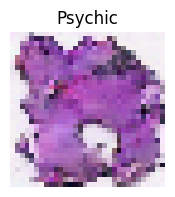

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 780ms/step - loss: 0.0933
Epoch 461/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0920
Epoch 462/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0723
Epoch 463/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0849
Epoch 464/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0788
Epoch 465/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0709
Epoch 466/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0791
Epoch 467/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0771
Epoch 468/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0812
Epoch 469/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0887
Epoch 470/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1005
Epoch 471/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0913
Epoch 472/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0861
Epoch 473/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0710
Epoch 474/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.95it/s]                         


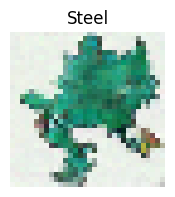

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 786ms/step - loss: 0.0803
Epoch 481/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0837
Epoch 482/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1028
Epoch 483/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1116
Epoch 484/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1012
Epoch 485/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1076
Epoch 486/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0700
Epoch 487/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0882
Epoch 488/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0883
Epoch 489/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1191
Epoch 490/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0808
Epoch 491/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0932
Epoch 492/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0651
Epoch 493/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1034
Epoch 494/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.99it/s]                         


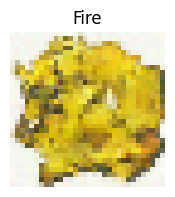

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 784ms/step - loss: 0.0824
Epoch 501/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0881
Epoch 502/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1013
Epoch 503/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0803
Epoch 504/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0863
Epoch 505/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0653
Epoch 506/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0787
Epoch 507/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0865
Epoch 508/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0876
Epoch 509/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0764
Epoch 510/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0905
Epoch 511/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0825
Epoch 512/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0831
Epoch 513/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1260
Epoch 514/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.83it/s]                         


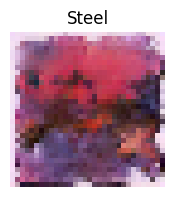

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0746
Epoch 521/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0948
Epoch 522/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0730
Epoch 523/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0847
Epoch 524/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1269
Epoch 525/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0765
Epoch 526/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0538
Epoch 527/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0847
Epoch 528/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0717
Epoch 529/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0878
Epoch 530/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0909
Epoch 531/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0798
Epoch 532/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0853
Epoch 533/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0829
Epoch 534/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.07it/s]                         


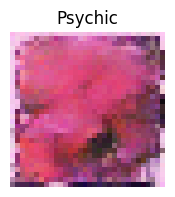

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 779ms/step - loss: 0.0898
Epoch 541/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0935
Epoch 542/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0637
Epoch 543/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0752
Epoch 544/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0790
Epoch 545/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0694
Epoch 546/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0785
Epoch 547/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0834
Epoch 548/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0962
Epoch 549/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0981
Epoch 550/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0858
Epoch 551/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0889
Epoch 552/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0777
Epoch 553/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0938
Epoch 554/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.90it/s]                         


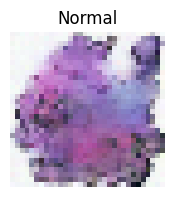

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 789ms/step - loss: 0.0900
Epoch 561/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0838
Epoch 562/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1065
Epoch 563/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0921
Epoch 564/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1098
Epoch 565/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0944
Epoch 566/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0740
Epoch 567/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0899
Epoch 568/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0904
Epoch 569/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0718
Epoch 570/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0653
Epoch 571/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0771
Epoch 572/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0782
Epoch 573/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0707
Epoch 574/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.02it/s]                         


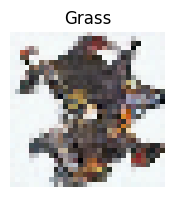

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 782ms/step - loss: 0.0957
Epoch 581/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0817
Epoch 582/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0767
Epoch 583/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0863
Epoch 584/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1155
Epoch 585/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0913
Epoch 586/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0838
Epoch 587/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0946
Epoch 588/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1258
Epoch 589/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0782
Epoch 590/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0768
Epoch 591/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0834
Epoch 592/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0910
Epoch 593/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0911
Epoch 594/600
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.98it/s]                         


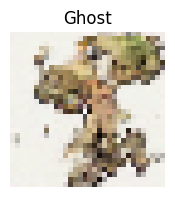

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 784ms/step - loss: 0.1001


In [6]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 500it [00:44, 11.31it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:44, 11.30it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.83it/s]                         


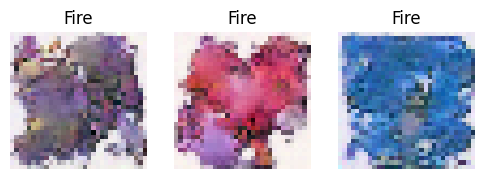

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.58it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.80it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.65it/s]                         


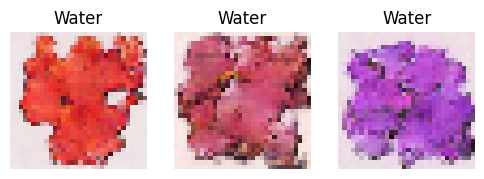

Generating sample 1/3


Sampling sprite: 500it [00:42, 11.87it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.89it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.69it/s]                         


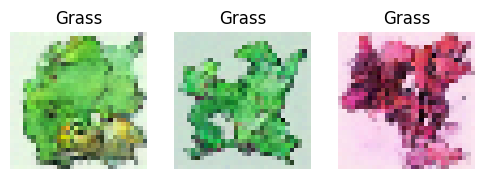

Generating sample 1/3


Sampling sprite: 500it [00:41, 11.96it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.76it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:41, 11.92it/s]                         


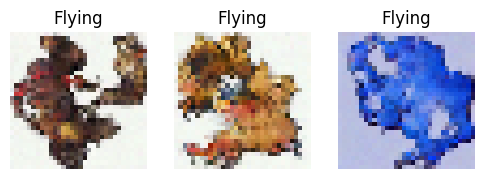

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.81it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.89it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:41, 12.02it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:41, 11.93it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:41, 11.93it/s]                         


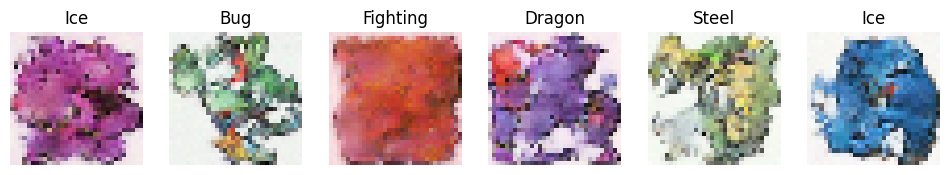

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.68it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.63it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:41, 12.03it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:41, 11.98it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.83it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.57it/s]                         


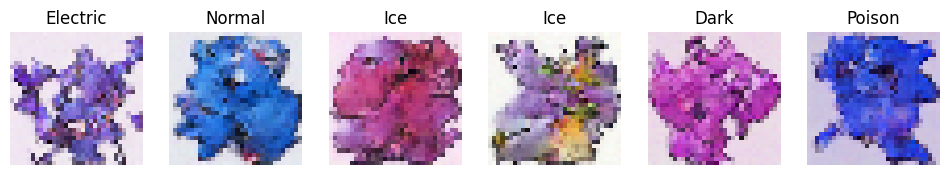

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.73it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:41, 11.94it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.76it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.90it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.78it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:41, 11.93it/s]                         


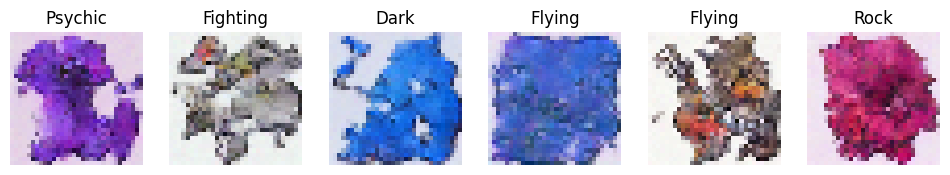

In [7]:
model.plot_samples(3, "Fire")
model.plot_samples(3, "Water")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Flying")
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

Epoch 1/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0802
Epoch 2/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0872
Epoch 3/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0739
Epoch 4/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0989
Epoch 5/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0832
Epoch 6/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0785
Epoch 7/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0864
Epoch 8/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0838
Epoch 9/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0856
Epoch 10/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0987
Epoch 11/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0798
Epoch 12/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0861
Epoch 13/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0919
Epoch 14/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0702
Epoch 15/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - lo

Sampling sprite: 500it [00:45, 11.05it/s]                         


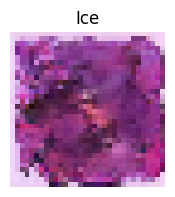

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 779ms/step - loss: 0.1066
Epoch 21/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0882
Epoch 22/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0702
Epoch 23/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0937
Epoch 24/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0905
Epoch 25/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0541
Epoch 26/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0759
Epoch 27/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0836
Epoch 28/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0497
Epoch 29/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0808
Epoch 30/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0664
Epoch 31/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0780
Epoch 32/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0924
Epoch 33/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0915
Epoch 34/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:44, 11.28it/s]                         


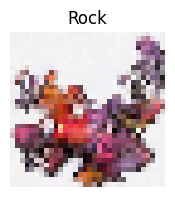

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 766ms/step - loss: 0.1146
Epoch 41/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0898
Epoch 42/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0963
Epoch 43/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0782
Epoch 44/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1122
Epoch 45/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0857
Epoch 46/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0722
Epoch 47/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0820
Epoch 48/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0825
Epoch 49/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0516
Epoch 50/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0754
Epoch 51/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0683
Epoch 52/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0866
Epoch 53/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0905
Epoch 54/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:45, 11.00it/s]                         


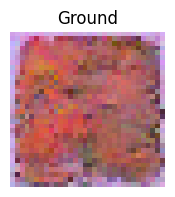

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 783ms/step - loss: 0.0928
Epoch 61/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0713
Epoch 62/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0854
Epoch 63/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0716
Epoch 64/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0594
Epoch 65/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1109
Epoch 66/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0911
Epoch 67/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0779
Epoch 68/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0833
Epoch 69/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0901
Epoch 70/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0842
Epoch 71/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0951
Epoch 72/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0815
Epoch 73/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0713
Epoch 74/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:44, 11.14it/s]                         


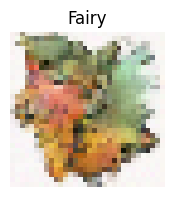

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 774ms/step - loss: 0.0794
Epoch 81/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0790
Epoch 82/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0696
Epoch 83/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0820
Epoch 84/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0983
Epoch 85/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0872
Epoch 86/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0862
Epoch 87/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0594
Epoch 88/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1111
Epoch 89/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0759
Epoch 90/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0747
Epoch 91/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0814
Epoch 92/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0639
Epoch 93/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0861
Epoch 94/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:45, 11.04it/s]                         


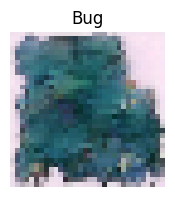

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 780ms/step - loss: 0.0703
Epoch 101/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1066
Epoch 102/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0858
Epoch 103/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0839
Epoch 104/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0685
Epoch 105/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1063
Epoch 106/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0817
Epoch 107/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0805
Epoch 108/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0684
Epoch 109/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0996
Epoch 110/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0930
Epoch 111/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0902
Epoch 112/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0490
Epoch 113/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0713
Epoch 114/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.91it/s]                         


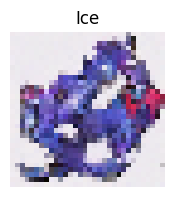

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - loss: 0.0908
Epoch 121/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1047
Epoch 122/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0933
Epoch 123/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1024
Epoch 124/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0842
Epoch 125/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0699
Epoch 126/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0883
Epoch 127/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0679
Epoch 128/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0851
Epoch 129/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0751
Epoch 130/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0705
Epoch 131/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0813
Epoch 132/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0849
Epoch 133/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0846
Epoch 134/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.17it/s]                         


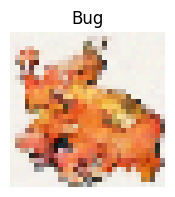

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 772ms/step - loss: 0.0887
Epoch 141/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0862
Epoch 142/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0681
Epoch 143/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0585
Epoch 144/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0858
Epoch 145/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0778
Epoch 146/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0802
Epoch 147/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0858
Epoch 148/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0856
Epoch 149/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0915
Epoch 150/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1015
Epoch 151/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0642
Epoch 152/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0981
Epoch 153/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0888
Epoch 154/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.73it/s]                         


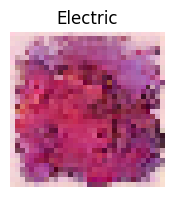

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 800ms/step - loss: 0.0841
Epoch 161/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0830
Epoch 162/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0903
Epoch 163/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0739
Epoch 164/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0848
Epoch 165/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0798
Epoch 166/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0814
Epoch 167/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0804
Epoch 168/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0719
Epoch 169/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0796
Epoch 170/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0785
Epoch 171/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0646
Epoch 172/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0607
Epoch 173/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0829
Epoch 174/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.03it/s]                         


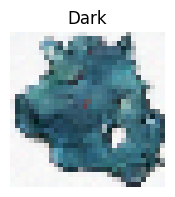

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 781ms/step - loss: 0.0592
Epoch 181/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0717
Epoch 182/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0853
Epoch 183/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0690
Epoch 184/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0962
Epoch 185/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0779
Epoch 186/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0990
Epoch 187/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0920
Epoch 188/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0935
Epoch 189/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0938
Epoch 190/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0893
Epoch 191/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0779
Epoch 192/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0909
Epoch 193/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0791
Epoch 194/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.82it/s]                         


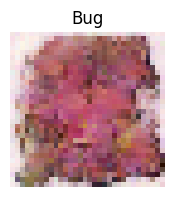

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 794ms/step - loss: 0.1012
Epoch 201/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0785
Epoch 202/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0747
Epoch 203/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0934
Epoch 204/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0944
Epoch 205/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0701
Epoch 206/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0718
Epoch 207/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0693
Epoch 208/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0737
Epoch 209/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0790
Epoch 210/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1102
Epoch 211/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1059
Epoch 212/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0714
Epoch 213/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0824
Epoch 214/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.04it/s]                         


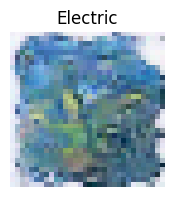

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 780ms/step - loss: 0.0961
Epoch 221/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0720
Epoch 222/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0583
Epoch 223/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0717
Epoch 224/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0760
Epoch 225/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0822
Epoch 226/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0686
Epoch 227/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0749
Epoch 228/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0655
Epoch 229/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0670
Epoch 230/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0736
Epoch 231/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0901
Epoch 232/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0707
Epoch 233/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1012
Epoch 234/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.87it/s]                         


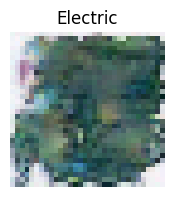

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.1081
Epoch 241/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0931
Epoch 242/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0884
Epoch 243/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0761
Epoch 244/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0728
Epoch 245/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0862
Epoch 246/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 247/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0737
Epoch 248/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0581
Epoch 249/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0821
Epoch 250/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0875
Epoch 251/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1012
Epoch 252/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0971
Epoch 253/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0904
Epoch 254/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.94it/s]                         


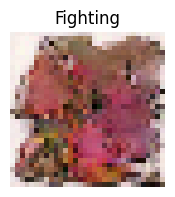

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 787ms/step - loss: 0.0733
Epoch 261/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0716
Epoch 262/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0633
Epoch 263/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0678
Epoch 264/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0656
Epoch 265/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0851
Epoch 266/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0769
Epoch 267/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0834
Epoch 268/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0940
Epoch 269/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0749
Epoch 270/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0924
Epoch 271/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0788
Epoch 272/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0651
Epoch 273/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1150
Epoch 274/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.98it/s]                         


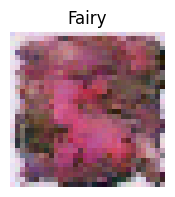

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 784ms/step - loss: 0.0835
Epoch 281/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0843
Epoch 282/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0660
Epoch 283/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0744
Epoch 284/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0923
Epoch 285/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0762
Epoch 286/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0884
Epoch 287/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0840
Epoch 288/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0726
Epoch 289/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0836
Epoch 290/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0621
Epoch 291/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0765
Epoch 292/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0930
Epoch 293/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0719
Epoch 294/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.93it/s]                         


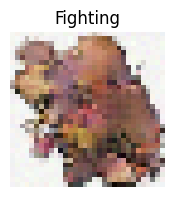

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 789ms/step - loss: 0.0586
Epoch 301/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0922
Epoch 302/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1154
Epoch 303/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0991
Epoch 304/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0805
Epoch 305/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0717
Epoch 306/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0919
Epoch 307/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0680
Epoch 308/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0921
Epoch 309/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0888
Epoch 310/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0962
Epoch 311/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0777
Epoch 312/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0889
Epoch 313/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0606
Epoch 314/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.92it/s]                         


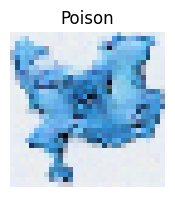

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - loss: 0.0935
Epoch 321/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0803
Epoch 322/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0912
Epoch 323/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0779
Epoch 324/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0853
Epoch 325/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0785
Epoch 326/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0760
Epoch 327/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0567
Epoch 328/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0970
Epoch 329/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0758
Epoch 330/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0804
Epoch 331/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0731
Epoch 332/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0741
Epoch 333/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0846
Epoch 334/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.90it/s]                         


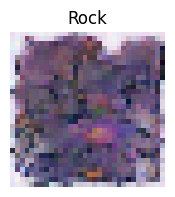

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 789ms/step - loss: 0.0769
Epoch 341/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1046
Epoch 342/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0822
Epoch 343/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1099
Epoch 344/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0988
Epoch 345/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0967
Epoch 346/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0666
Epoch 347/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0642
Epoch 348/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0740
Epoch 349/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0880
Epoch 350/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0850
Epoch 351/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0945
Epoch 352/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0731
Epoch 353/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0704
Epoch 354/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.94it/s]                         


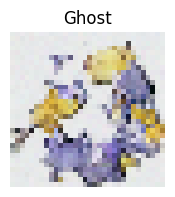

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0875
Epoch 361/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0975
Epoch 362/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0830
Epoch 363/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0893
Epoch 364/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0822
Epoch 365/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0807
Epoch 366/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0797
Epoch 367/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0701
Epoch 368/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0950
Epoch 369/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0784
Epoch 370/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0758
Epoch 371/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0730
Epoch 372/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0877
Epoch 373/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 374/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.77it/s]                         


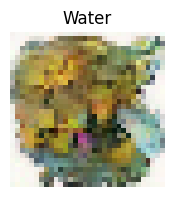

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 800ms/step - loss: 0.0598
Epoch 381/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0823
Epoch 382/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0650
Epoch 383/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0798
Epoch 384/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0851
Epoch 385/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0881
Epoch 386/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0782
Epoch 387/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0665
Epoch 388/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0760
Epoch 389/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0732
Epoch 390/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0666
Epoch 391/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0795
Epoch 392/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0775
Epoch 393/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0703
Epoch 394/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.02it/s]                         


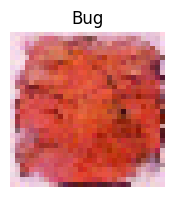

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 783ms/step - loss: 0.0890
Epoch 401/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0942
Epoch 402/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0843
Epoch 403/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0653
Epoch 404/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0764
Epoch 405/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0840
Epoch 406/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1016
Epoch 407/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0794
Epoch 408/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0798
Epoch 409/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0951
Epoch 410/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0842
Epoch 411/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0892
Epoch 412/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0955
Epoch 413/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0972
Epoch 414/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.97it/s]                         


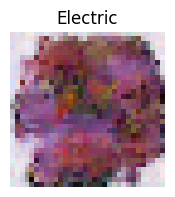

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 785ms/step - loss: 0.0833
Epoch 421/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0581
Epoch 422/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0734
Epoch 423/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0673
Epoch 424/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0658
Epoch 425/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0680
Epoch 426/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0769
Epoch 427/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0587
Epoch 428/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0733
Epoch 429/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0678
Epoch 430/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0943
Epoch 431/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0811
Epoch 432/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0756
Epoch 433/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0676
Epoch 434/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.02it/s]                         


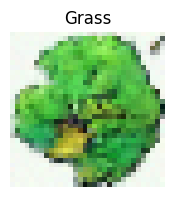

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 782ms/step - loss: 0.0720
Epoch 441/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0684
Epoch 442/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0742
Epoch 443/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0754
Epoch 444/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0900
Epoch 445/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0734
Epoch 446/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0849
Epoch 447/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0610
Epoch 448/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0861
Epoch 449/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0879
Epoch 450/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0807
Epoch 451/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0688
Epoch 452/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0798
Epoch 453/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0832
Epoch 454/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.97it/s]                         


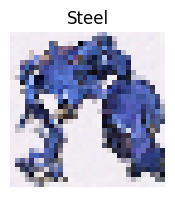

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 785ms/step - loss: 0.0763
Epoch 461/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0542
Epoch 462/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0793
Epoch 463/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0842
Epoch 464/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0824
Epoch 465/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0809
Epoch 466/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 467/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0804
Epoch 468/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0744
Epoch 469/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0812
Epoch 470/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0690
Epoch 471/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0922
Epoch 472/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0778
Epoch 473/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0787
Epoch 474/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.83it/s]                         


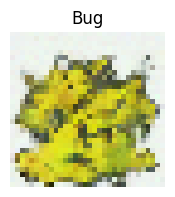

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 795ms/step - loss: 0.1123
Epoch 481/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0626
Epoch 482/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0871
Epoch 483/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0974
Epoch 484/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0744
Epoch 485/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0626
Epoch 486/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0663
Epoch 487/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0679
Epoch 488/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0888
Epoch 489/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0777
Epoch 490/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0695
Epoch 491/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0957
Epoch 492/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0787
Epoch 493/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0787
Epoch 494/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.86it/s]                         


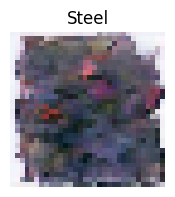

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0750
Epoch 501/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0995
Epoch 502/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0622
Epoch 503/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0732
Epoch 504/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0555
Epoch 505/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0757
Epoch 506/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0662
Epoch 507/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0592
Epoch 508/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0949
Epoch 509/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0684
Epoch 510/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0926
Epoch 511/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0867
Epoch 512/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0884
Epoch 513/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0691
Epoch 514/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.76it/s]                         


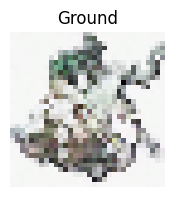

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 800ms/step - loss: 0.0629
Epoch 521/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0740
Epoch 522/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0829
Epoch 523/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0619
Epoch 524/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0863
Epoch 525/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0876
Epoch 526/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0548
Epoch 527/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0767
Epoch 528/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1062
Epoch 529/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0873
Epoch 530/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0712
Epoch 531/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0834
Epoch 532/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0656
Epoch 533/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0801
Epoch 534/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:44, 11.15it/s]                         


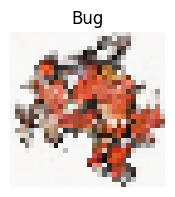

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 775ms/step - loss: 0.0686
Epoch 541/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0778
Epoch 542/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0602
Epoch 543/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0733
Epoch 544/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0796
Epoch 545/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0802
Epoch 546/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0797
Epoch 547/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0858
Epoch 548/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0899
Epoch 549/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1092
Epoch 550/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0588
Epoch 551/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0741
Epoch 552/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 553/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0764
Epoch 554/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.07it/s]                         


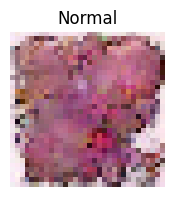

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 779ms/step - loss: 0.0970
Epoch 561/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0816
Epoch 562/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0873
Epoch 563/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0714
Epoch 564/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0711
Epoch 565/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0584
Epoch 566/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0786
Epoch 567/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0753
Epoch 568/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0798
Epoch 569/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0781
Epoch 570/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0784
Epoch 571/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0860
Epoch 572/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0878
Epoch 573/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0810
Epoch 574/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.88it/s]                         


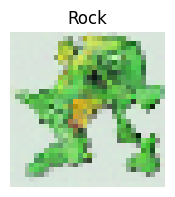

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0807
Epoch 581/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0926
Epoch 582/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0676
Epoch 583/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0638
Epoch 584/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0608
Epoch 585/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1100
Epoch 586/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0891
Epoch 587/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0793
Epoch 588/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0659
Epoch 589/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0570
Epoch 590/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0701
Epoch 591/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0898
Epoch 592/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0733
Epoch 593/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1011
Epoch 594/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.86it/s]                         


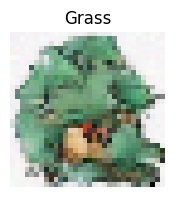

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 792ms/step - loss: 0.0648
Epoch 601/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0641
Epoch 602/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0799
Epoch 603/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0831
Epoch 604/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1054
Epoch 605/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 606/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0760
Epoch 607/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0787
Epoch 608/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0876
Epoch 609/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 610/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0830
Epoch 611/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0786
Epoch 612/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1038
Epoch 613/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0874
Epoch 614/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.77it/s]                         


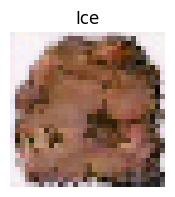

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 799ms/step - loss: 0.0923
Epoch 621/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0719
Epoch 622/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0870
Epoch 623/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0741
Epoch 624/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0767
Epoch 625/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0752
Epoch 626/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1066
Epoch 627/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0798
Epoch 628/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0630
Epoch 629/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0777
Epoch 630/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0717
Epoch 631/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0858
Epoch 632/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0762
Epoch 633/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0556
Epoch 634/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.93it/s]                         


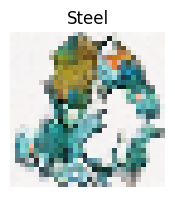

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 787ms/step - loss: 0.0672
Epoch 641/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0790
Epoch 642/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0739
Epoch 643/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0849
Epoch 644/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0754
Epoch 645/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0758
Epoch 646/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0686
Epoch 647/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0648
Epoch 648/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0722
Epoch 649/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0663
Epoch 650/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0845
Epoch 651/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0809
Epoch 652/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0780
Epoch 653/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0873
Epoch 654/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.93it/s]                         


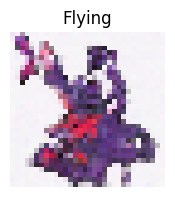

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - loss: 0.0864
Epoch 661/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0613
Epoch 662/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0677
Epoch 663/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0611
Epoch 664/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0582
Epoch 665/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0899
Epoch 666/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0793
Epoch 667/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0729
Epoch 668/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0699
Epoch 669/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0768
Epoch 670/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0858
Epoch 671/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0792
Epoch 672/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1005
Epoch 673/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0715
Epoch 674/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.92it/s]                         


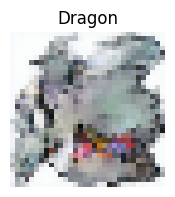

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 789ms/step - loss: 0.0743
Epoch 681/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0685
Epoch 682/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0687
Epoch 683/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0854
Epoch 684/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0693
Epoch 685/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0810
Epoch 686/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0776
Epoch 687/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0640
Epoch 688/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0654
Epoch 689/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0735
Epoch 690/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0716
Epoch 691/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0686
Epoch 692/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0651
Epoch 693/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0773
Epoch 694/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.98it/s]                         


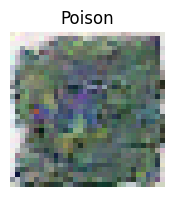

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 784ms/step - loss: 0.0869


In [8]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=700, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 500it [00:44, 11.29it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:44, 11.32it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:43, 11.39it/s]                         


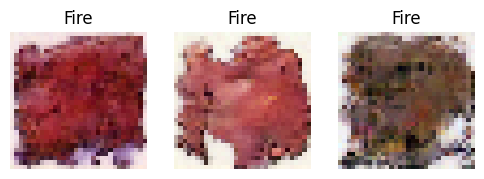

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.55it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:43, 11.47it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.81it/s]                         


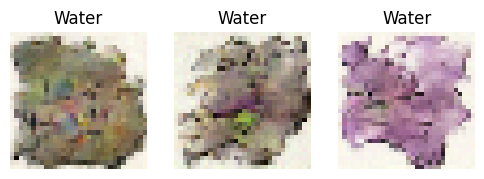

Generating sample 1/3


Sampling sprite: 500it [00:42, 11.74it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.80it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.69it/s]                         


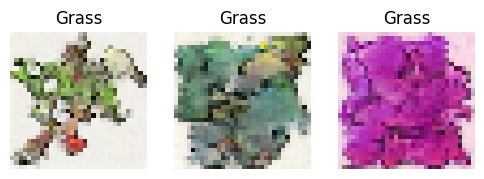

Generating sample 1/3


Sampling sprite: 500it [00:42, 11.81it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:43, 11.47it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.72it/s]                         


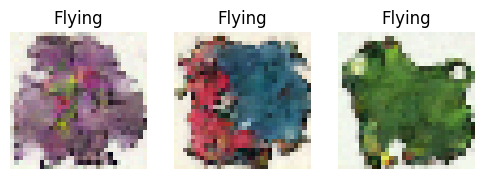

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.77it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.78it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.77it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.72it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.73it/s]                         


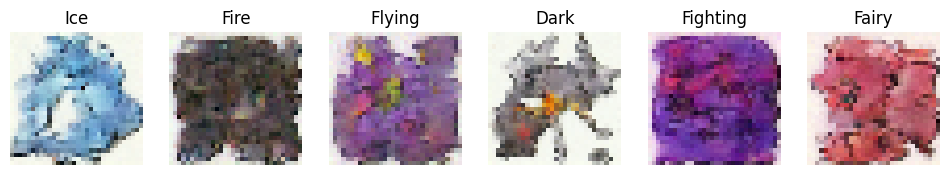

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.85it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.76it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.61it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.55it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:41, 11.93it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:41, 11.94it/s]                         


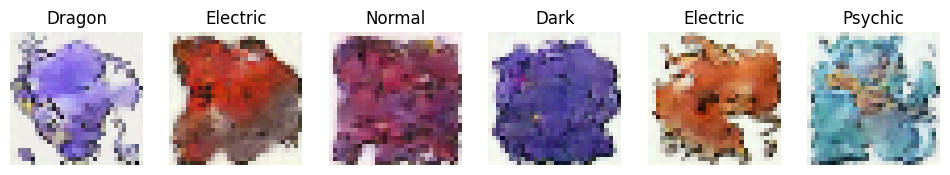

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.72it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.53it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:41, 11.93it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.55it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.63it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


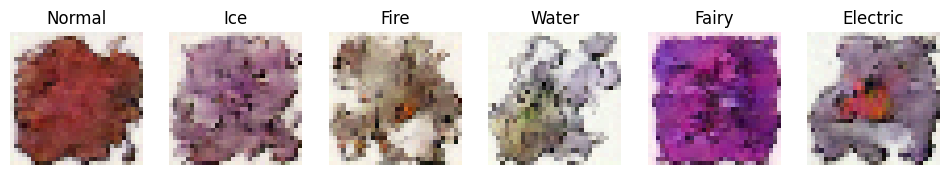

In [9]:
model.plot_samples(3, "Fire")
model.plot_samples(3, "Water")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Flying")
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

Epoch 1/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0894
Epoch 2/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0686
Epoch 3/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0721
Epoch 4/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0784
Epoch 5/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0861
Epoch 6/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0782
Epoch 7/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0746
Epoch 8/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0756
Epoch 9/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0942
Epoch 10/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0738
Epoch 11/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0717
Epoch 12/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0460
Epoch 13/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0663
Epoch 14/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0782
Epoch 15/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - lo

Sampling sprite: 500it [00:44, 11.16it/s]                         


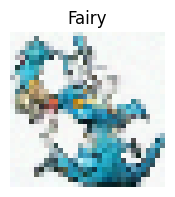

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 773ms/step - loss: 0.0755
Epoch 21/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0704
Epoch 22/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0838
Epoch 23/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0668
Epoch 24/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0653
Epoch 25/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0761
Epoch 26/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0860
Epoch 27/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0907
Epoch 28/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0766
Epoch 29/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0964
Epoch 30/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0508
Epoch 31/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0794
Epoch 32/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0566
Epoch 33/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0743
Epoch 34/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:45, 11.02it/s]                         


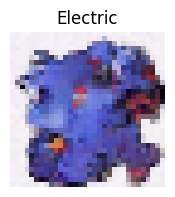

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 781ms/step - loss: 0.0571
Epoch 41/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0729
Epoch 42/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0896
Epoch 43/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0687
Epoch 44/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0764
Epoch 45/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0847
Epoch 46/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0799
Epoch 47/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0730
Epoch 48/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0625
Epoch 49/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0706
Epoch 50/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0620
Epoch 51/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0925
Epoch 52/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0669
Epoch 53/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0813
Epoch 54/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:44, 11.13it/s]                         


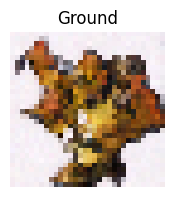

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 775ms/step - loss: 0.0787
Epoch 61/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0936
Epoch 62/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0847
Epoch 63/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0863
Epoch 64/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0723
Epoch 65/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0528
Epoch 66/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0555
Epoch 67/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0745
Epoch 68/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0741
Epoch 69/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0912
Epoch 70/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0969
Epoch 71/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0678
Epoch 72/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0821
Epoch 73/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0713
Epoch 74/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:44, 11.21it/s]                         


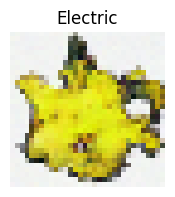

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 770ms/step - loss: 0.0607
Epoch 81/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0743
Epoch 82/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0825
Epoch 83/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0595
Epoch 84/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0646
Epoch 85/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0609
Epoch 86/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0799
Epoch 87/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0793
Epoch 88/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0627
Epoch 89/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0852
Epoch 90/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 91/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0768
Epoch 92/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0581
Epoch 93/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0671
Epoch 94/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:45, 10.93it/s]                         


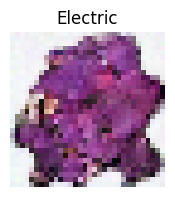

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 789ms/step - loss: 0.0998
Epoch 101/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0664
Epoch 102/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0847
Epoch 103/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0875
Epoch 104/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0707
Epoch 105/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0554
Epoch 106/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0811
Epoch 107/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0817
Epoch 108/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0669
Epoch 109/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0617
Epoch 110/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0518
Epoch 111/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0778
Epoch 112/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0716
Epoch 113/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0734
Epoch 114/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.87it/s]                         


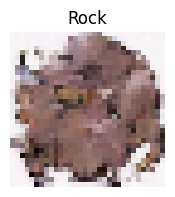

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 792ms/step - loss: 0.0689
Epoch 121/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0773
Epoch 122/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0677
Epoch 123/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0687
Epoch 124/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0951
Epoch 125/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0725
Epoch 126/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0714
Epoch 127/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0942
Epoch 128/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0660
Epoch 129/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0947
Epoch 130/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0616
Epoch 131/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0637
Epoch 132/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0823
Epoch 133/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0888
Epoch 134/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.66it/s]                         


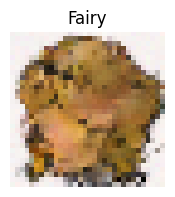

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 805ms/step - loss: 0.1068
Epoch 141/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0749
Epoch 142/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0778
Epoch 143/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0682
Epoch 144/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0706
Epoch 145/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0746
Epoch 146/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0854
Epoch 147/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0874
Epoch 148/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0753
Epoch 149/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0658
Epoch 150/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0867
Epoch 151/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0807
Epoch 152/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0947
Epoch 153/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0784
Epoch 154/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.81it/s]                         


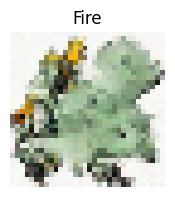

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 795ms/step - loss: 0.0937
Epoch 161/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0908
Epoch 162/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0893
Epoch 163/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0768
Epoch 164/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0740
Epoch 165/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0711
Epoch 166/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0751
Epoch 167/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0588
Epoch 168/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0630
Epoch 169/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0574
Epoch 170/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0799
Epoch 171/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0765
Epoch 172/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0735
Epoch 173/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0829
Epoch 174/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.84it/s]                         


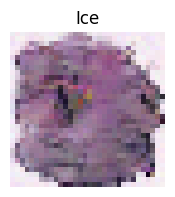

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 796ms/step - loss: 0.0825
Epoch 181/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0806
Epoch 182/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0705
Epoch 183/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0844
Epoch 184/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0787
Epoch 185/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0817
Epoch 186/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0674
Epoch 187/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0690
Epoch 188/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0519
Epoch 189/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0795
Epoch 190/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0815
Epoch 191/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0849
Epoch 192/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0635
Epoch 193/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0640
Epoch 194/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.90it/s]                         


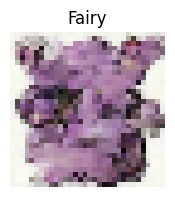

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 792ms/step - loss: 0.0729
Epoch 201/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0608
Epoch 202/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0766
Epoch 203/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0790
Epoch 204/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0754
Epoch 205/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0832
Epoch 206/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0749
Epoch 207/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0667
Epoch 208/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 209/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0784
Epoch 210/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0838
Epoch 211/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0724
Epoch 212/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0639
Epoch 213/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0871
Epoch 214/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.88it/s]                         


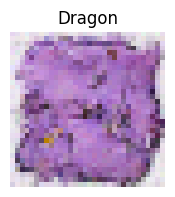

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0717
Epoch 221/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0632
Epoch 222/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0635
Epoch 223/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0814
Epoch 224/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0744
Epoch 225/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0708
Epoch 226/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0776
Epoch 227/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0898
Epoch 228/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0716
Epoch 229/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0705
Epoch 230/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0887
Epoch 231/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0912
Epoch 232/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0786
Epoch 233/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0712
Epoch 234/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.90it/s]                         


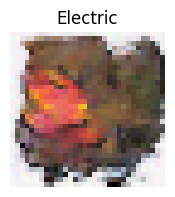

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0729
Epoch 241/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0828
Epoch 242/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0823
Epoch 243/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0741
Epoch 244/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0795
Epoch 245/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0696
Epoch 246/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0780
Epoch 247/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0928
Epoch 248/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0757
Epoch 249/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0628
Epoch 250/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0581
Epoch 251/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0788
Epoch 252/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0658
Epoch 253/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0893
Epoch 254/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.83it/s]                         


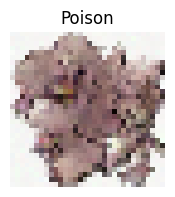

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 794ms/step - loss: 0.0656
Epoch 261/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0829
Epoch 262/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0684
Epoch 263/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0664
Epoch 264/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0771
Epoch 265/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0778
Epoch 266/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0592
Epoch 267/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0689
Epoch 268/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0716
Epoch 269/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0870
Epoch 270/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0867
Epoch 271/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0851
Epoch 272/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0833
Epoch 273/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0733
Epoch 274/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.88it/s]                         


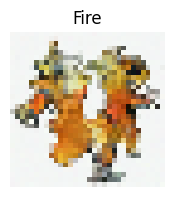

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0857
Epoch 281/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0661
Epoch 282/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0703
Epoch 283/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0715
Epoch 284/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0757
Epoch 285/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0634
Epoch 286/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0644
Epoch 287/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0778
Epoch 288/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0920
Epoch 289/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0712
Epoch 290/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0650
Epoch 291/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0594
Epoch 292/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0816
Epoch 293/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0947
Epoch 294/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99

Sampling sprite: 500it [00:45, 10.97it/s]                         


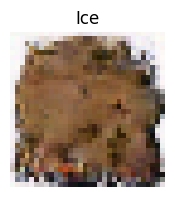

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 787ms/step - loss: 0.0664
Epoch 301/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0974
Epoch 302/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0816
Epoch 303/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0551
Epoch 304/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0857
Epoch 305/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0728
Epoch 306/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0807
Epoch 307/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0839
Epoch 308/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 309/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0739
Epoch 310/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0728
Epoch 311/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0965
Epoch 312/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0690
Epoch 313/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0687
Epoch 314/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.81it/s]                         


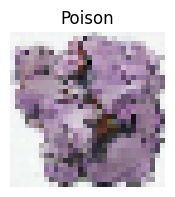

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 797ms/step - loss: 0.0610
Epoch 321/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0737
Epoch 322/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0660
Epoch 323/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1093
Epoch 324/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0705
Epoch 325/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0762
Epoch 326/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0524
Epoch 327/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0851
Epoch 328/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0716
Epoch 329/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0838
Epoch 330/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0739
Epoch 331/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0753
Epoch 332/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0627
Epoch 333/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0833
Epoch 334/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.94it/s]                         


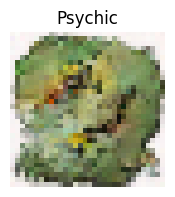

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - loss: 0.0858
Epoch 341/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0848
Epoch 342/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0769
Epoch 343/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0887
Epoch 344/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0803
Epoch 345/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0914
Epoch 346/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0692
Epoch 347/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0665
Epoch 348/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0709
Epoch 349/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0718
Epoch 350/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0634
Epoch 351/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0677
Epoch 352/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0781
Epoch 353/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0723
Epoch 354/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:45, 10.94it/s]                         


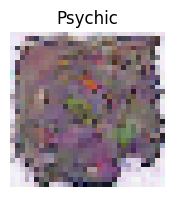

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - loss: 0.0581
Epoch 361/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0719
Epoch 362/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0594
Epoch 363/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0992
Epoch 364/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0605
Epoch 365/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0850
Epoch 366/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0732
Epoch 367/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0646
Epoch 368/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0714
Epoch 369/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0755
Epoch 370/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0658
Epoch 371/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0681
Epoch 372/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0657
Epoch 373/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0775
Epoch 374/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.84it/s]                         


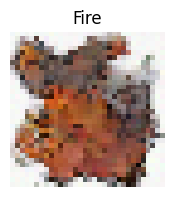

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 795ms/step - loss: 0.0671
Epoch 381/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0799
Epoch 382/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0716
Epoch 383/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0816
Epoch 384/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0682
Epoch 385/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0841
Epoch 386/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0948
Epoch 387/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0877
Epoch 388/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0740
Epoch 389/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 390/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0688
Epoch 391/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0777
Epoch 392/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0665
Epoch 393/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0609
Epoch 394/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.71it/s]                         


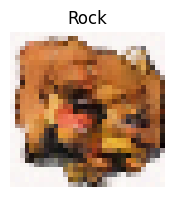

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 804ms/step - loss: 0.0662
Epoch 401/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0597
Epoch 402/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0798
Epoch 403/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0883
Epoch 404/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0767
Epoch 405/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0652
Epoch 406/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0671
Epoch 407/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0830
Epoch 408/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0748
Epoch 409/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0897
Epoch 410/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0733
Epoch 411/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0806
Epoch 412/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0519
Epoch 413/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0518
Epoch 414/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:47, 10.64it/s]                         


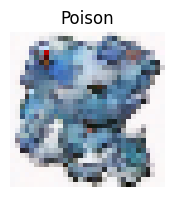

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 808ms/step - loss: 0.0783
Epoch 421/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0650
Epoch 422/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0787
Epoch 423/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0609
Epoch 424/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0748
Epoch 425/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0885
Epoch 426/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0626
Epoch 427/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0637
Epoch 428/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0900
Epoch 429/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0647
Epoch 430/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0795
Epoch 431/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0807
Epoch 432/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0781
Epoch 433/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0839
Epoch 434/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:47, 10.47it/s]                         


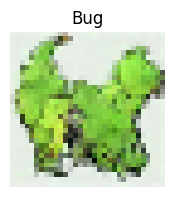

68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 818ms/step - loss: 0.0756
Epoch 441/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0926
Epoch 442/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0893
Epoch 443/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0710
Epoch 444/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0687
Epoch 445/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0615
Epoch 446/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0789
Epoch 447/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0714
Epoch 448/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0645
Epoch 449/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0695
Epoch 450/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0675
Epoch 451/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0743
Epoch 452/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0986
Epoch 453/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0880
Epoch 454/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99

Sampling sprite: 500it [00:46, 10.65it/s]                         


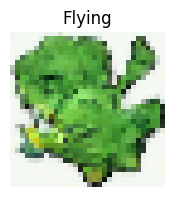

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 807ms/step - loss: 0.0666
Epoch 461/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0893
Epoch 462/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0762
Epoch 463/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0626
Epoch 464/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0585
Epoch 465/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0755
Epoch 466/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0878
Epoch 467/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0715
Epoch 468/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0830
Epoch 469/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0976
Epoch 470/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0632
Epoch 471/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0629
Epoch 472/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0672
Epoch 473/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0679
Epoch 474/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99

Sampling sprite: 500it [00:46, 10.83it/s]                         


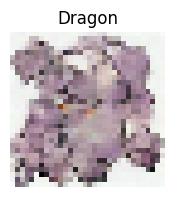

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 796ms/step - loss: 0.0802
Epoch 481/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0771
Epoch 482/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0847
Epoch 483/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0624
Epoch 484/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0606
Epoch 485/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0922
Epoch 486/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0732
Epoch 487/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0643
Epoch 488/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0591
Epoch 489/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0723
Epoch 490/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0835
Epoch 491/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0680
Epoch 492/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0572
Epoch 493/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 494/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.71it/s]                         


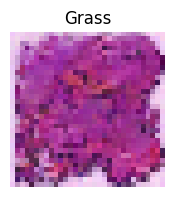

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 803ms/step - loss: 0.0805
Epoch 501/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0723
Epoch 502/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0723
Epoch 503/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0830
Epoch 504/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0727
Epoch 505/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1093
Epoch 506/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0802
Epoch 507/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0688
Epoch 508/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0647
Epoch 509/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0590
Epoch 510/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0756
Epoch 511/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0753
Epoch 512/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0636
Epoch 513/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0782
Epoch 514/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.93it/s]                         


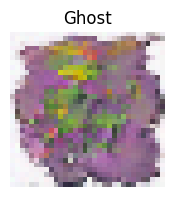

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - loss: 0.0591
Epoch 521/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0583
Epoch 522/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0689
Epoch 523/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0839
Epoch 524/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0759
Epoch 525/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0823
Epoch 526/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0697
Epoch 527/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0854
Epoch 528/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0778
Epoch 529/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0921
Epoch 530/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0611
Epoch 531/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0721
Epoch 532/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0758
Epoch 533/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0599
Epoch 534/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.79it/s]                         


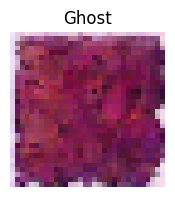

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 798ms/step - loss: 0.0855
Epoch 541/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0652
Epoch 542/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0742
Epoch 543/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0676
Epoch 544/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0596
Epoch 545/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0597
Epoch 546/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0659
Epoch 547/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0837
Epoch 548/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0791
Epoch 549/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0888
Epoch 550/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0792
Epoch 551/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0700
Epoch 552/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0623
Epoch 553/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0630
Epoch 554/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99

Sampling sprite: 500it [00:46, 10.74it/s]                         


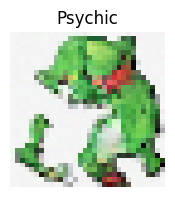

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 802ms/step - loss: 0.0629
Epoch 561/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0662
Epoch 562/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0715
Epoch 563/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0743
Epoch 564/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0410
Epoch 565/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0677
Epoch 566/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1028
Epoch 567/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0836
Epoch 568/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0705
Epoch 569/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1030
Epoch 570/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1052
Epoch 571/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0808
Epoch 572/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 573/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0829
Epoch 574/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.94it/s]                         


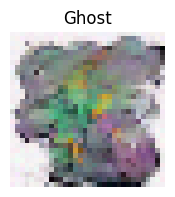

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - loss: 0.0819
Epoch 581/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0924
Epoch 582/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0751
Epoch 583/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0695
Epoch 584/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0772
Epoch 585/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0679
Epoch 586/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0646
Epoch 587/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0626
Epoch 588/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0600
Epoch 589/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0745
Epoch 590/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0721
Epoch 591/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0770
Epoch 592/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0596
Epoch 593/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0741
Epoch 594/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.71it/s]                         


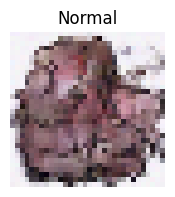

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 804ms/step - loss: 0.0639
Epoch 601/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0648
Epoch 602/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0755
Epoch 603/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0818
Epoch 604/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0720
Epoch 605/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0752
Epoch 606/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0730
Epoch 607/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0825
Epoch 608/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0579
Epoch 609/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0670
Epoch 610/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0702
Epoch 611/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0737
Epoch 612/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0734
Epoch 613/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0999
Epoch 614/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.77it/s]                         


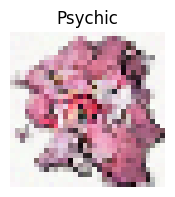

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 799ms/step - loss: 0.0605
Epoch 621/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0771
Epoch 622/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0864
Epoch 623/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0612
Epoch 624/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0689
Epoch 625/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0702
Epoch 626/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0629
Epoch 627/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0793
Epoch 628/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0779
Epoch 629/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0734
Epoch 630/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0832
Epoch 631/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0717
Epoch 632/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0797
Epoch 633/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0557
Epoch 634/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.88it/s]                         


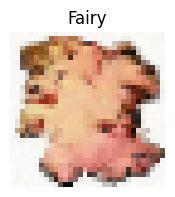

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0775
Epoch 641/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0732
Epoch 642/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0636
Epoch 643/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0674
Epoch 644/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0950
Epoch 645/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0735
Epoch 646/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0678
Epoch 647/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0554
Epoch 648/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0627
Epoch 649/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 650/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0629
Epoch 651/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0921
Epoch 652/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0656
Epoch 653/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0524
Epoch 654/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.97it/s]                         


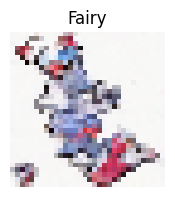

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 787ms/step - loss: 0.0703
Epoch 661/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0591
Epoch 662/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0574
Epoch 663/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0753
Epoch 664/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0730
Epoch 665/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0531
Epoch 666/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0674
Epoch 667/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0753
Epoch 668/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0952
Epoch 669/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0842
Epoch 670/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0697
Epoch 671/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0804
Epoch 672/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0599
Epoch 673/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0731
Epoch 674/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.83it/s]                         


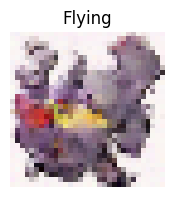

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 795ms/step - loss: 0.0829
Epoch 681/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0639
Epoch 682/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0760
Epoch 683/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0992
Epoch 684/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0797
Epoch 685/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0799
Epoch 686/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0736
Epoch 687/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0782
Epoch 688/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0563
Epoch 689/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0755
Epoch 690/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0732
Epoch 691/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0835
Epoch 692/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0515
Epoch 693/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0593
Epoch 694/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.78it/s]                         


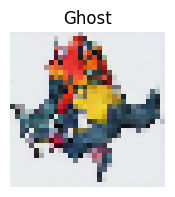

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 799ms/step - loss: 0.0971


In [10]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=700, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 500it [00:44, 11.16it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:43, 11.40it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:43, 11.61it/s]                         


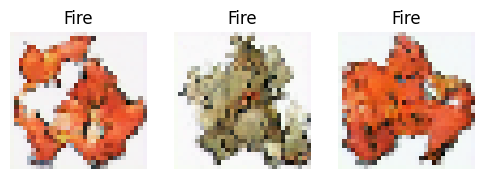

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.48it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:43, 11.58it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:43, 11.60it/s]                         


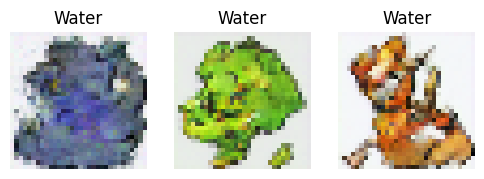

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.43it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:43, 11.44it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.64it/s]                         


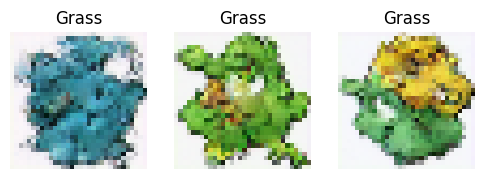

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.63it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.63it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.65it/s]                         


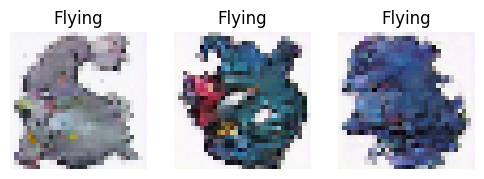

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.79it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.80it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.70it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.65it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.53it/s]                         


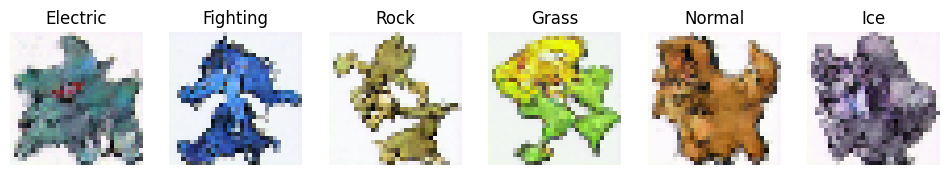

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.59it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.74it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.71it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.77it/s]                         


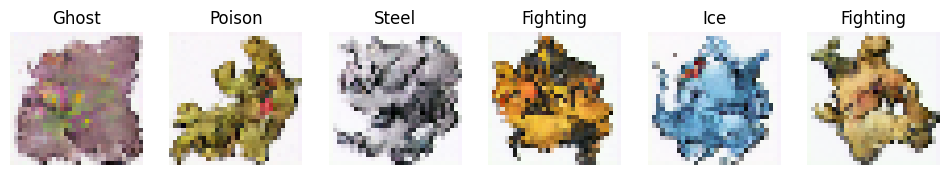

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.61it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.66it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.66it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.75it/s]                         


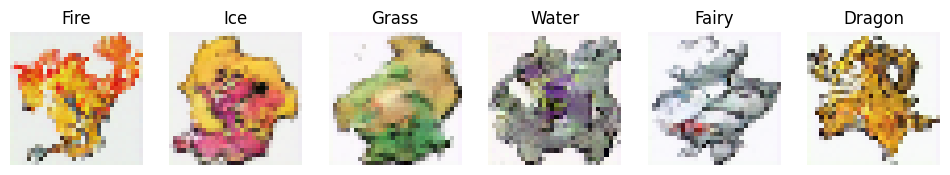

In [11]:
model.plot_samples(3, "Fire")
model.plot_samples(3, "Water")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Flying")
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

Epoch 1/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0789
Epoch 2/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0744
Epoch 3/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0723
Epoch 4/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0894
Epoch 5/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0824
Epoch 6/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0810
Epoch 7/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0656
Epoch 8/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0659
Epoch 9/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0731
Epoch 10/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0612
Epoch 11/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0778
Epoch 12/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0635
Epoch 13/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0757
Epoch 14/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0699
Epoch 15/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - lo

Sampling sprite: 500it [00:44, 11.19it/s]                         


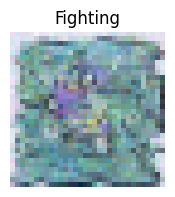

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 771ms/step - loss: 0.0501
Epoch 21/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0539
Epoch 22/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1005
Epoch 23/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0661
Epoch 24/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1004
Epoch 25/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0747
Epoch 26/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0637
Epoch 27/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0566
Epoch 28/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0814
Epoch 29/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0679
Epoch 30/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0669
Epoch 31/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0945
Epoch 32/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0790
Epoch 33/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0735
Epoch 34/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:46, 10.78it/s]                         


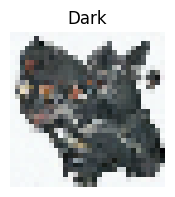

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 797ms/step - loss: 0.0722
Epoch 41/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0842
Epoch 42/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0694
Epoch 43/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0651
Epoch 44/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0765
Epoch 45/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0672
Epoch 46/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0633
Epoch 47/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0683
Epoch 48/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1116
Epoch 49/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0602
Epoch 50/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0888
Epoch 51/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0768
Epoch 52/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0651
Epoch 53/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0706
Epoch 54/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:45, 11.00it/s]                         


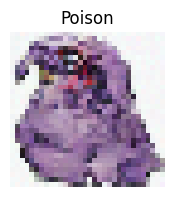

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 783ms/step - loss: 0.0730
Epoch 61/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0621
Epoch 62/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0704
Epoch 63/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0762
Epoch 64/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0772
Epoch 65/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0684
Epoch 66/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0725
Epoch 67/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0647
Epoch 68/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0666
Epoch 69/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0690
Epoch 70/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0682
Epoch 71/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0604
Epoch 72/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0872
Epoch 73/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0614
Epoch 74/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:45, 10.87it/s]                         


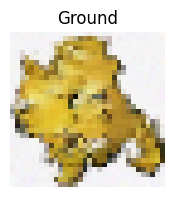

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 792ms/step - loss: 0.0843
Epoch 81/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0659
Epoch 82/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0520
Epoch 83/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0709
Epoch 84/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0547
Epoch 85/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0580
Epoch 86/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0661
Epoch 87/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0589
Epoch 88/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0652
Epoch 89/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0542
Epoch 90/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0905
Epoch 91/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0648
Epoch 92/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0792
Epoch 93/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0635
Epoch 94/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss

Sampling sprite: 500it [00:46, 10.81it/s]                         


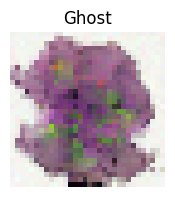

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 798ms/step - loss: 0.0553
Epoch 101/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0770
Epoch 102/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0812
Epoch 103/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0753
Epoch 104/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0691
Epoch 105/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0738
Epoch 106/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0711
Epoch 107/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0682
Epoch 108/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0665
Epoch 109/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0915
Epoch 110/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0826
Epoch 111/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1056
Epoch 112/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0665
Epoch 113/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0504
Epoch 114/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99

Sampling sprite: 500it [00:45, 10.87it/s]                         


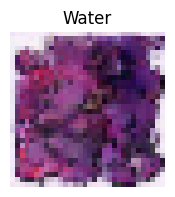

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0817
Epoch 121/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0877
Epoch 122/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0686
Epoch 123/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0623
Epoch 124/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0508
Epoch 125/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0754
Epoch 126/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0797
Epoch 127/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0751
Epoch 128/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0760
Epoch 129/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0705
Epoch 130/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0700
Epoch 131/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0792
Epoch 132/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0643
Epoch 133/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0821
Epoch 134/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:45, 10.91it/s]                         


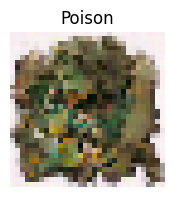

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0626
Epoch 141/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0505
Epoch 142/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0917
Epoch 143/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0850
Epoch 144/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0734
Epoch 145/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0795
Epoch 146/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0908
Epoch 147/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0680
Epoch 148/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0736
Epoch 149/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0629
Epoch 150/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0764
Epoch 151/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0724
Epoch 152/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0836
Epoch 153/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0625
Epoch 154/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 9

Sampling sprite: 500it [00:45, 11.04it/s]                         


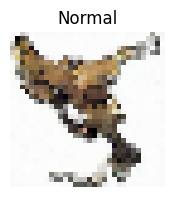

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 783ms/step - loss: 0.0762
Epoch 161/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0817
Epoch 162/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0755
Epoch 163/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0686
Epoch 164/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0892
Epoch 165/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0635
Epoch 166/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0610
Epoch 167/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0965
Epoch 168/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0658
Epoch 169/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0637
Epoch 170/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0663
Epoch 171/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0528
Epoch 172/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0727
Epoch 173/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0776
Epoch 174/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:45, 10.95it/s]                         


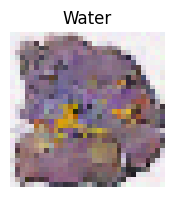

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - loss: 0.0768
Epoch 181/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0820
Epoch 182/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0700
Epoch 183/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0632
Epoch 184/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0750
Epoch 185/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0641
Epoch 186/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0727
Epoch 187/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0768
Epoch 188/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 189/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0868
Epoch 190/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0756
Epoch 191/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0613
Epoch 192/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.1114
Epoch 193/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0544
Epoch 194/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:46, 10.85it/s]                         


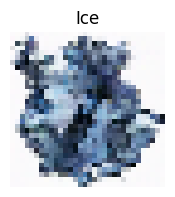

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 795ms/step - loss: 0.0759
Epoch 201/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0653
Epoch 202/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0714
Epoch 203/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0755
Epoch 204/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0565
Epoch 205/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0769
Epoch 206/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0828
Epoch 207/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0661
Epoch 208/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0606
Epoch 209/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0661
Epoch 210/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0687
Epoch 211/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0826
Epoch 212/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0788
Epoch 213/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0748
Epoch 214/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 

Sampling sprite: 500it [00:46, 10.71it/s]                         


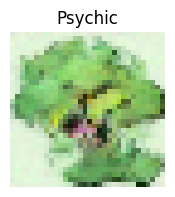

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 804ms/step - loss: 0.0927
Epoch 221/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0733
Epoch 222/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0639
Epoch 223/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0795
Epoch 224/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0618
Epoch 225/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0689
Epoch 226/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0792
Epoch 227/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0546
Epoch 228/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0683
Epoch 229/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0527
Epoch 230/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0734
Epoch 231/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0602
Epoch 232/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0619
Epoch 233/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0674
Epoch 234/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.83it/s]                         


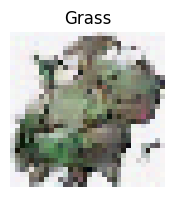

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 798ms/step - loss: 0.0588
Epoch 241/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0695
Epoch 242/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0751
Epoch 243/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0688
Epoch 244/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0667
Epoch 245/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0830
Epoch 246/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0659
Epoch 247/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0724
Epoch 248/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0650
Epoch 249/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0862
Epoch 250/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0837
Epoch 251/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0750
Epoch 252/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0755
Epoch 253/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0641
Epoch 254/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:45, 10.94it/s]                         


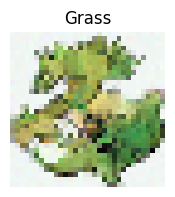

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 789ms/step - loss: 0.0663
Epoch 261/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0786
Epoch 262/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0701
Epoch 263/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0535
Epoch 264/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0903
Epoch 265/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0548
Epoch 266/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1099
Epoch 267/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0584
Epoch 268/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0680
Epoch 269/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0704
Epoch 270/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0657
Epoch 271/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0617
Epoch 272/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0656
Epoch 273/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0769
Epoch 274/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:45, 10.87it/s]                         


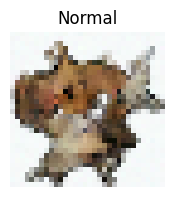

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - loss: 0.0728
Epoch 281/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0657
Epoch 282/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0865
Epoch 283/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0732
Epoch 284/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0655
Epoch 285/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0619
Epoch 286/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0921
Epoch 287/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0749
Epoch 288/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0625
Epoch 289/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0735
Epoch 290/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0871
Epoch 291/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0747
Epoch 292/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0699
Epoch 293/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0872
Epoch 294/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:44, 11.16it/s]                         


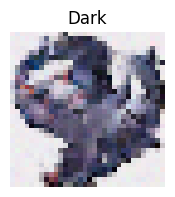

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 776ms/step - loss: 0.0818
Epoch 301/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0681
Epoch 302/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0513
Epoch 303/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0846
Epoch 304/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0798
Epoch 305/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 306/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0713
Epoch 307/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0809
Epoch 308/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0780
Epoch 309/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0724
Epoch 310/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0757
Epoch 311/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0655
Epoch 312/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0494
Epoch 313/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0876
Epoch 314/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 

Sampling sprite: 500it [00:47, 10.63it/s]                         


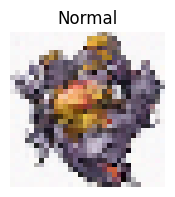

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 810ms/step - loss: 0.0703
Epoch 321/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0567
Epoch 322/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0530
Epoch 323/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0641
Epoch 324/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0852
Epoch 325/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0728
Epoch 326/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0656
Epoch 327/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0671
Epoch 328/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0575
Epoch 329/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0684
Epoch 330/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0852
Epoch 331/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0875
Epoch 332/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0739
Epoch 333/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0699
Epoch 334/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.75it/s]                         


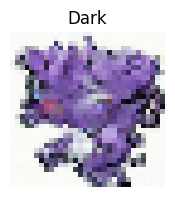

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 801ms/step - loss: 0.0555
Epoch 341/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0697
Epoch 342/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0673
Epoch 343/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0782
Epoch 344/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0624
Epoch 345/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0679
Epoch 346/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0684
Epoch 347/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0549
Epoch 348/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0585
Epoch 349/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0719
Epoch 350/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0515
Epoch 351/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0738
Epoch 352/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0791
Epoch 353/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0601
Epoch 354/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.69it/s]                         


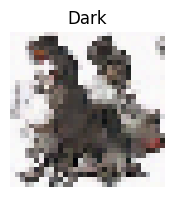

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 805ms/step - loss: 0.0668
Epoch 361/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0648
Epoch 362/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0844
Epoch 363/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0698
Epoch 364/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0727
Epoch 365/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0476
Epoch 366/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0570
Epoch 367/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0685
Epoch 368/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0871
Epoch 369/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0566
Epoch 370/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0682
Epoch 371/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0744
Epoch 372/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0606
Epoch 373/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0876
Epoch 374/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:46, 10.84it/s]                         


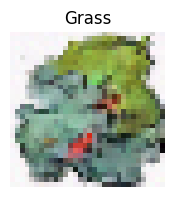

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 797ms/step - loss: 0.0764
Epoch 381/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0777
Epoch 382/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0661
Epoch 383/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0669
Epoch 384/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0712
Epoch 385/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0685
Epoch 386/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0788
Epoch 387/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0871
Epoch 388/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0575
Epoch 389/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0853
Epoch 390/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0654
Epoch 391/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0720
Epoch 392/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0846
Epoch 393/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0633
Epoch 394/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:46, 10.76it/s]                         


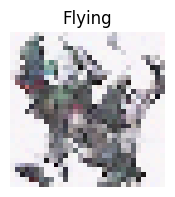

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 801ms/step - loss: 0.0549
Epoch 401/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0644
Epoch 402/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0562
Epoch 403/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0588
Epoch 404/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1012
Epoch 405/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0602
Epoch 406/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0833
Epoch 407/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0740
Epoch 408/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0849
Epoch 409/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0797
Epoch 410/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0690
Epoch 411/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0783
Epoch 412/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0780
Epoch 413/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0823
Epoch 414/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:45, 10.90it/s]                         


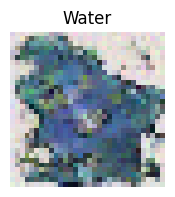

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0664
Epoch 421/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0977
Epoch 422/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0834
Epoch 423/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0523
Epoch 424/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0958
Epoch 425/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0637
Epoch 426/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0616
Epoch 427/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0646
Epoch 428/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0584
Epoch 429/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 430/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0723
Epoch 431/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0599
Epoch 432/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0786
Epoch 433/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0831
Epoch 434/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s

Sampling sprite: 500it [00:46, 10.83it/s]                         


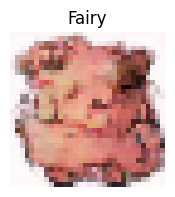

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 797ms/step - loss: 0.0593
Epoch 441/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0789
Epoch 442/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0829
Epoch 443/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0535
Epoch 444/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0724
Epoch 445/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0555
Epoch 446/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0687
Epoch 447/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0766
Epoch 448/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0796
Epoch 449/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0737
Epoch 450/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0667
Epoch 451/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0691
Epoch 452/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0858
Epoch 453/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0803
Epoch 454/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 

Sampling sprite: 500it [00:46, 10.76it/s]                         


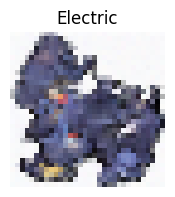

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 800ms/step - loss: 0.0754
Epoch 461/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0670
Epoch 462/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0655
Epoch 463/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0878
Epoch 464/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0788
Epoch 465/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0885
Epoch 466/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0656
Epoch 467/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0757
Epoch 468/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0415
Epoch 469/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0707
Epoch 470/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0642
Epoch 471/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0644
Epoch 472/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0729
Epoch 473/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0652
Epoch 474/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 10

Sampling sprite: 500it [00:45, 10.95it/s]                         


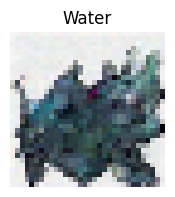

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - loss: 0.0849
Epoch 481/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0783
Epoch 482/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0768
Epoch 483/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0730
Epoch 484/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0540
Epoch 485/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0472
Epoch 486/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0628
Epoch 487/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0667
Epoch 488/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0636
Epoch 489/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0716
Epoch 490/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0621
Epoch 491/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0849
Epoch 492/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0663
Epoch 493/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0527
Epoch 494/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 9

Sampling sprite: 500it [00:45, 11.01it/s]                         


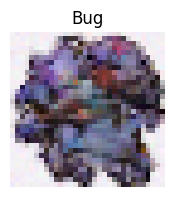

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 785ms/step - loss: 0.0574
Epoch 501/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0675
Epoch 502/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0896
Epoch 503/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0798
Epoch 504/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0614
Epoch 505/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0652
Epoch 506/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0857
Epoch 507/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0733
Epoch 508/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0621
Epoch 509/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0647
Epoch 510/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0613
Epoch 511/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0663
Epoch 512/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0616
Epoch 513/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0577
Epoch 514/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 1

Sampling sprite: 500it [00:45, 11.02it/s]                         


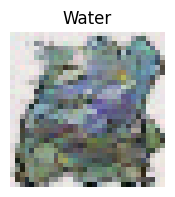

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 784ms/step - loss: 0.0654
Epoch 521/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0578
Epoch 522/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0486
Epoch 523/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0617
Epoch 524/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0596
Epoch 525/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0695
Epoch 526/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0646
Epoch 527/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0639
Epoch 528/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0852
Epoch 529/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0771
Epoch 530/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0747
Epoch 531/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0769
Epoch 532/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0849
Epoch 533/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0548
Epoch 534/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 

Sampling sprite: 500it [00:46, 10.66it/s]                         


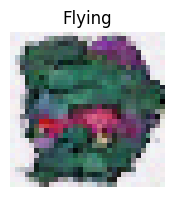

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 807ms/step - loss: 0.0923
Epoch 541/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0727
Epoch 542/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0566
Epoch 543/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0737
Epoch 544/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0630
Epoch 545/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0506
Epoch 546/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0730
Epoch 547/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0538
Epoch 548/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0816
Epoch 549/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0632
Epoch 550/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0607
Epoch 551/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0690
Epoch 552/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0811
Epoch 553/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0612
Epoch 554/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7

Sampling sprite: 500it [00:48, 10.33it/s]                         


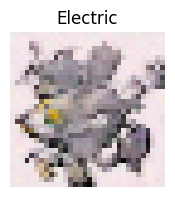

68/68 ━━━━━━━━━━━━━━━━━━━━ 56s 830ms/step - loss: 0.0464
Epoch 561/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0759
Epoch 562/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0630
Epoch 563/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0584
Epoch 564/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0830
Epoch 565/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0713
Epoch 566/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0552
Epoch 567/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0562
Epoch 568/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0595
Epoch 569/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0658
Epoch 570/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0718
Epoch 571/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0730
Epoch 572/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0790
Epoch 573/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0518
Epoch 574/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:47, 10.62it/s]                         


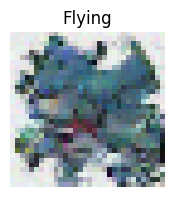

68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 813ms/step - loss: 0.0618
Epoch 581/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0681
Epoch 582/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0675
Epoch 583/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0890
Epoch 584/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0657
Epoch 585/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0894
Epoch 586/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0576
Epoch 587/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0846
Epoch 588/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0770
Epoch 589/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0641
Epoch 590/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0825
Epoch 591/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0651
Epoch 592/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0677
Epoch 593/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0681
Epoch 594/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:46, 10.76it/s]                         


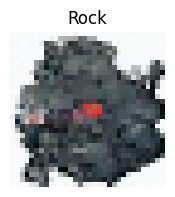

68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 798ms/step - loss: 0.0670
Epoch 601/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0712
Epoch 602/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0534
Epoch 603/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0689
Epoch 604/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0656
Epoch 605/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0657
Epoch 606/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0478
Epoch 607/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0604
Epoch 608/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0540
Epoch 609/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0759
Epoch 610/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0714
Epoch 611/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0727
Epoch 612/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0707
Epoch 613/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0620
Epoch 614/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.03it/s]                         


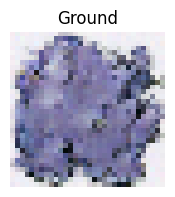

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 781ms/step - loss: 0.0852
Epoch 621/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0585
Epoch 622/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0660
Epoch 623/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0748
Epoch 624/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0765
Epoch 625/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0823
Epoch 626/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0618
Epoch 627/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0595
Epoch 628/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0627
Epoch 629/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0625
Epoch 630/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0661
Epoch 631/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0772
Epoch 632/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0460
Epoch 633/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0627
Epoch 634/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.95it/s]                         


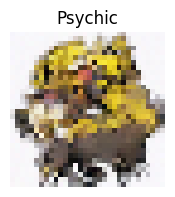

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 786ms/step - loss: 0.0920
Epoch 641/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0723
Epoch 642/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0772
Epoch 643/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0800
Epoch 644/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0803
Epoch 645/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0535
Epoch 646/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0597
Epoch 647/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0616
Epoch 648/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0863
Epoch 649/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0726
Epoch 650/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0750
Epoch 651/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0421
Epoch 652/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0788
Epoch 653/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0808
Epoch 654/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 10.97it/s]                         


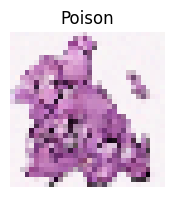

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 785ms/step - loss: 0.0825
Epoch 661/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0817
Epoch 662/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0706
Epoch 663/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0745
Epoch 664/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0605
Epoch 665/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0689
Epoch 666/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0541
Epoch 667/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0639
Epoch 668/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0641
Epoch 669/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0581
Epoch 670/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0658
Epoch 671/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0532
Epoch 672/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0688
Epoch 673/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0876
Epoch 674/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98

Sampling sprite: 500it [00:45, 11.01it/s]                         


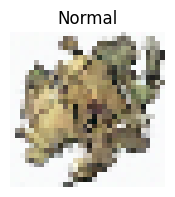

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 782ms/step - loss: 0.0613
Epoch 681/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0752
Epoch 682/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0757
Epoch 683/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0508
Epoch 684/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0834
Epoch 685/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0579
Epoch 686/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0469
Epoch 687/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0698
Epoch 688/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0802
Epoch 689/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0528
Epoch 690/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0534
Epoch 691/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0614
Epoch 692/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0613
Epoch 693/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0733
Epoch 694/700
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97

Sampling sprite: 500it [00:45, 10.95it/s]                         


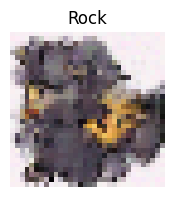

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 786ms/step - loss: 0.0675


In [12]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=700, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.51it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.67it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:43, 11.62it/s]                         


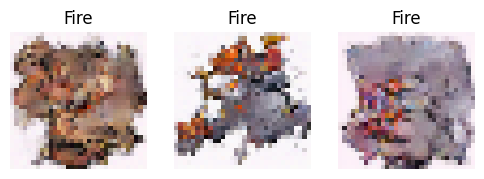

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.59it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.67it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.77it/s]                         


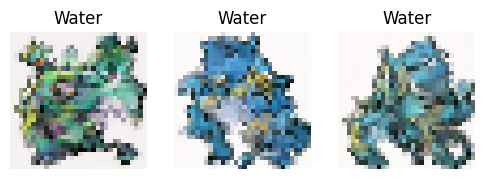

Generating sample 1/3


Sampling sprite: 500it [00:42, 11.80it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.68it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:43, 11.48it/s]                         


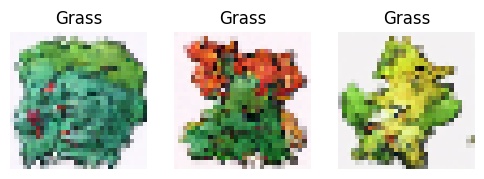

Generating sample 1/3


Sampling sprite: 500it [00:43, 11.61it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:42, 11.70it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:42, 11.77it/s]                         


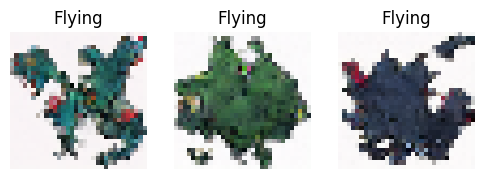

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.52it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.61it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.72it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.80it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.77it/s]                         


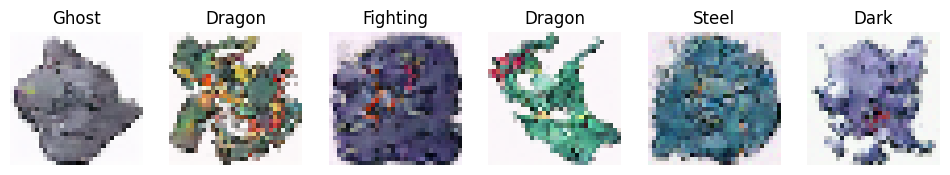

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.65it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.77it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.65it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.66it/s]                         


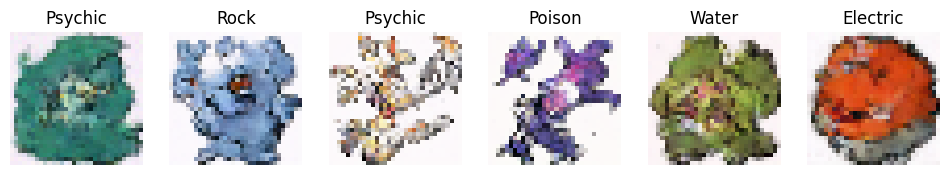

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.64it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.76it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.70it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.70it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.58it/s]                         


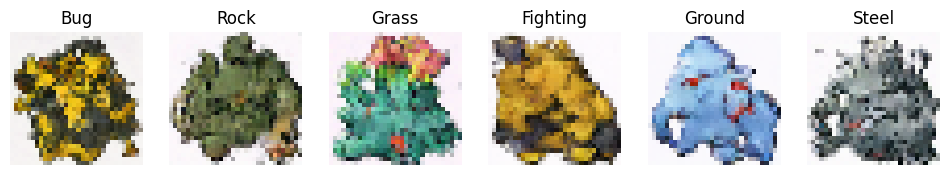

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.75it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.61it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.81it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.75it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.72it/s]                         


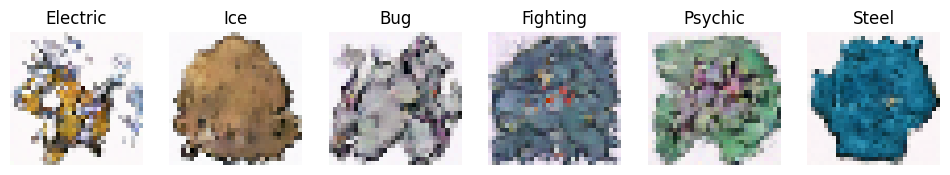

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.79it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.57it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.56it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.78it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.70it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


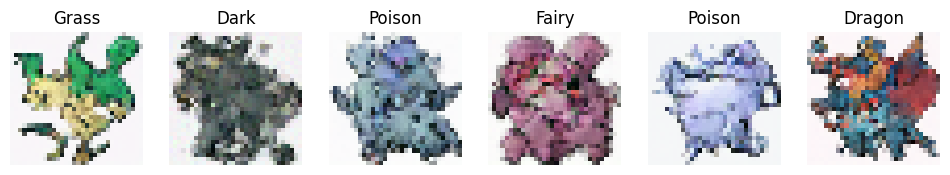

In [13]:
model.plot_samples(3, "Fire")
model.plot_samples(3, "Water")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Flying")
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.80it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.56it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.49it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.38it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:44, 11.16it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:44, 11.18it/s]                         


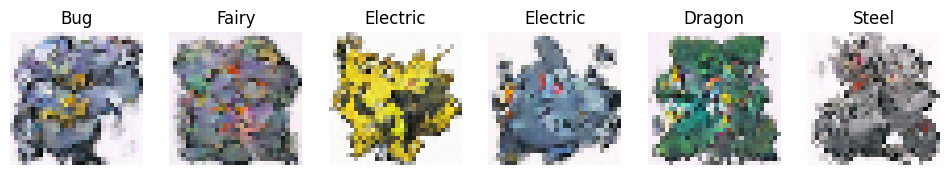

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.42it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.48it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.49it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.64it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.55it/s]                         


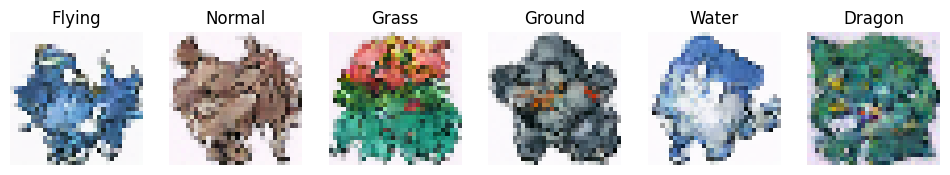

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.66it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.71it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.52it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.63it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.45it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.61it/s]                         


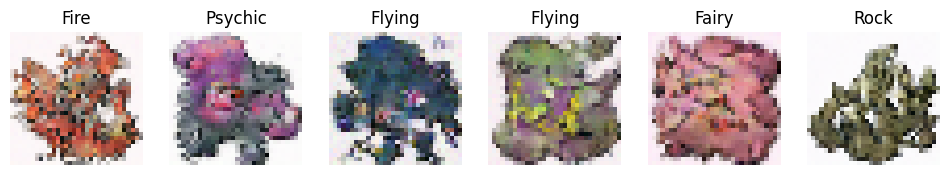

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.75it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.64it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.71it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.63it/s]                         


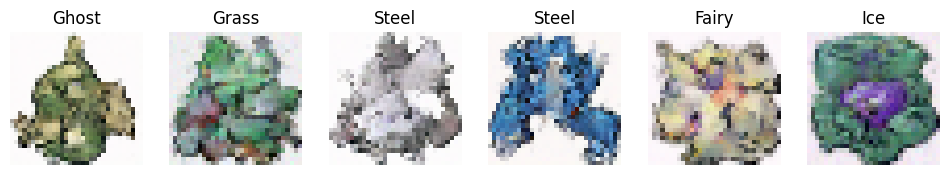

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.59it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.58it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.64it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.57it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.57it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.52it/s]                         


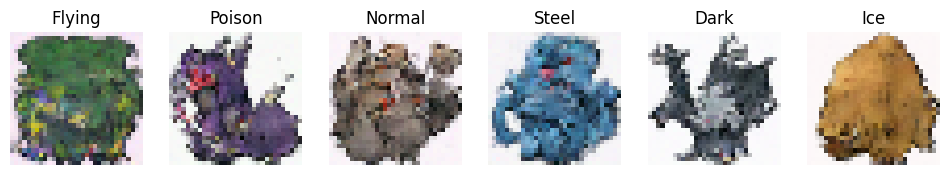

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.66it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.72it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.48it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.51it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.61it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.49it/s]                         


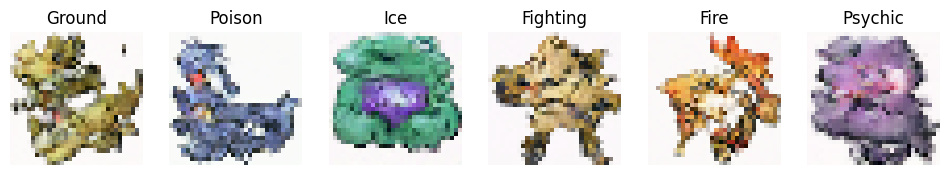

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.63it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.52it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.63it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.64it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.60it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.57it/s]                         


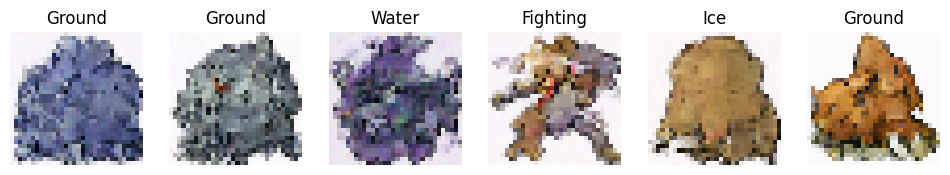

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.69it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.73it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.64it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.52it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.44it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.58it/s]                         


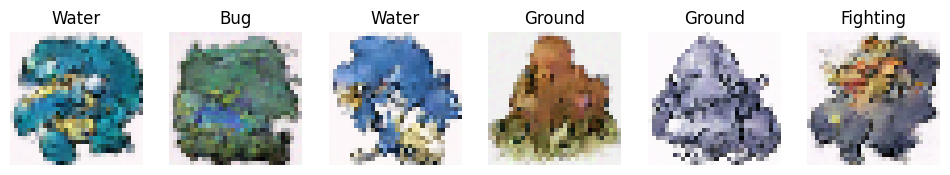

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.59it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:42, 11.74it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.58it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.44it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:42, 11.70it/s]                         


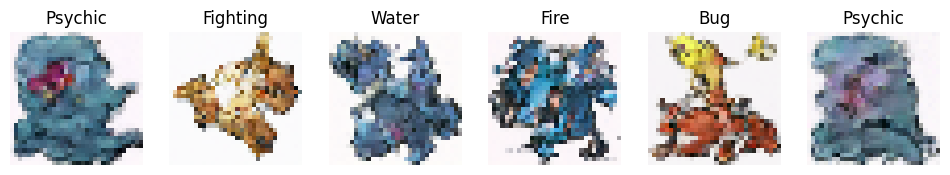

Generating sample 1/6


Sampling sprite: 500it [00:42, 11.71it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.48it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.79it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:42, 11.72it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:43, 11.45it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.55it/s]                         


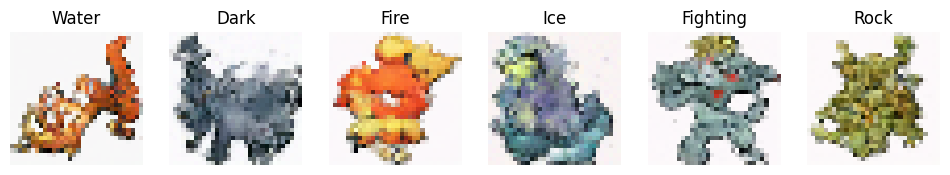

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.46it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:42, 11.88it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.44it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:44, 11.29it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.54it/s]                         


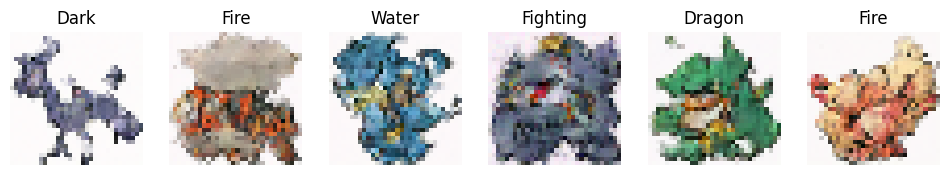

Generating sample 1/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:43, 11.62it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:43, 11.56it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:43, 11.56it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:42, 11.70it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:43, 11.59it/s]                         


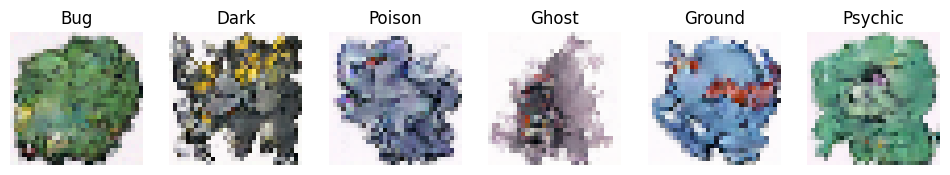

In [20]:
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

### 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [21]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [22]:
# Save the model
SCHEDULER = "linear"
EPOCHS = "muchos"
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm_attention_time_sin"

save_model(model, model_name)

Model diffusion_32_60_muchos_500_linear_ddpm_attention_time_sin, saved successfully!


In [16]:
# # load the model
# # =====================================================================
# model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

# model_load.plot_samples(6)

[BACK TO TOP](#test)

[BACK TO TOP](#test)